# Face Recognition Project

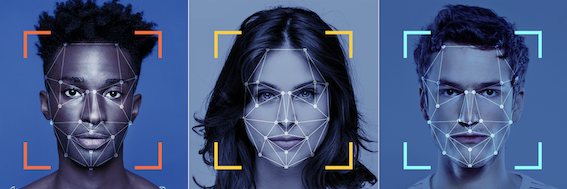

In this project you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

This basic notebook will give you 8/10 points, if completed fully. There are also additional features you might implement to get additional points. You may do additional tasks and receive additional points even if you didn't fully complete the basic notebook. This means you can choose which tasks to do. **Additional features that you might implement are listed in Telegram chat**.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

As you see on the site, images of celebA dataset look like this:


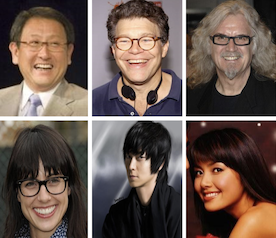

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

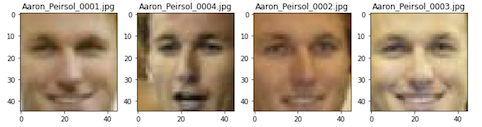

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

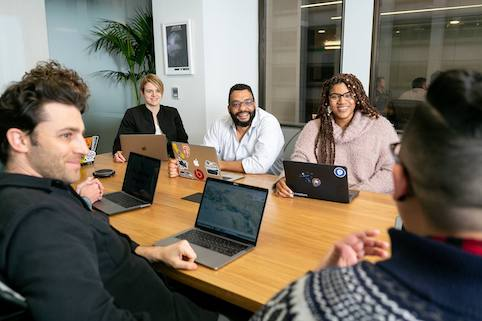

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

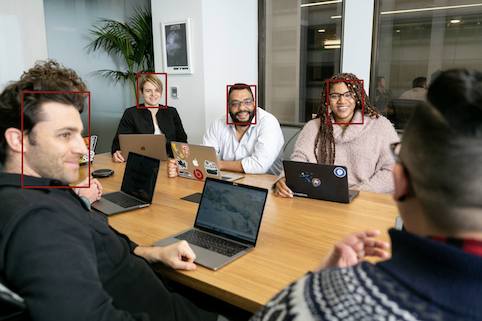

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

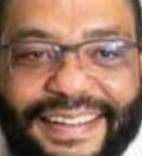

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

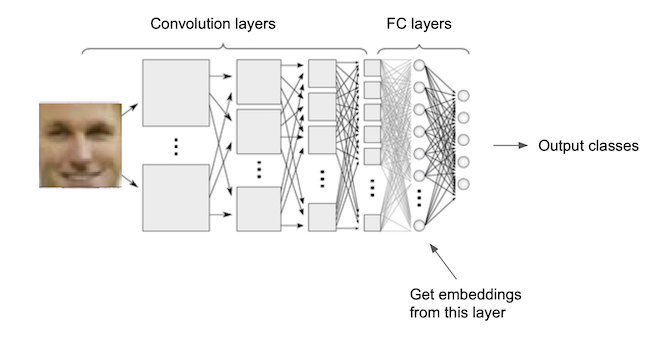

## Build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw or using the code below:

- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import torch.optim as optim

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import datetime
from torchmetrics import JaccardIndex
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

Let's visualize some images to understand what we're dealing with:

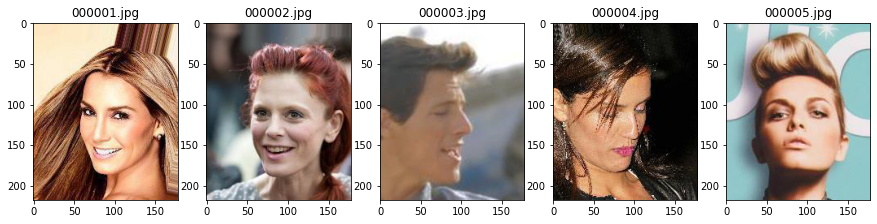

In [7]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
        img = Image.open(os.path.join('/celebA_train_500/celebA_imgs/', img))
        imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('/celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [3]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('/celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('/celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('/celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.aug:
            image = self.aug(image)
            sample = {
                'image': image,
                'label': label,
            }
        else:
            sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        return sample

In [4]:
transform = transforms.Compose([
      # you may add anything, e.g. augmentation
    transforms.CenterCrop((120,120)),  
    transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)])
train_data = celebADataset('train', transform, augmentation)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

# choose your own batch_size
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [120]:
X = iter(train_loader).next()
X['label']


tensor([ 65,  29,  88,  33, 145, 175, 406, 172,  81,   6, 218, 395, 464, 108,
        123, 122,  64, 132, 396, 149,  87, 473, 415, 345, 474, 454, 339, 410,
        352,  97, 146, 131,  55, 249, 307, 163, 410, 464, 212, 285, 162, 358,
        285, 250, 354, 290, 169, 266, 482, 212, 177,  77,  64, 447, 458, 200,
        212, 140, 239, 377, 301,  83, 130,  71])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


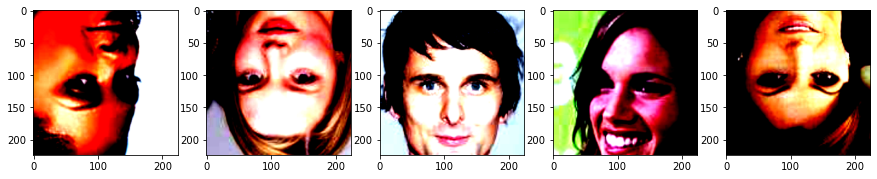

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(3*5, 9*5))
for i in range(5):
    landscape = X['image'][i].permute(1, 2, 0).cpu().detach().numpy()
    axes[i].imshow(landscape)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [6]:
import pretrainedmodels
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [39]:
print(pretrainedmodels.pretrained_settings['resnet18'])

{'imagenet': {'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [19]:
import pretrainedmodels 
print(pretrainedmodels.pretrained_settings['resnet18'])
models = pretrainedmodels.__dict__['resnet18'](num_classes=1000, pretrained='imagenet')

{'imagenet': {'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [7]:
import torchvision
import pretrainedmodels
import torchvision.models as models
pretrained_model = pretrainedmodels.__dict__['resnet18'](num_classes=1000, pretrained='imagenet')
class resnet18(nn.Module):
    def __init__(self, pretrained_model):
        super(resnet18, self).__init__()
        self.pretrained = pretrained_model
        self.new_layers = nn.Linear(1000, 500)
    
    def forward(self, X):
        X = self.pretrained(X)
        X = self.new_layers(X)
        return X

model = resnet18(pretrained_model=pretrained_model)
model

resnet18(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [44]:
model.state_dict()

OrderedDict([('pretrained.conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                     

In [8]:
from torchsummary import summary
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1000]                --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         295,424
|    └─Sequential: 2-7                   [-1, 256, 14, 14]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 14, 14]     

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1000]                --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         295,424
|    └─Sequential: 2-7                   [-1, 256, 14, 14]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 14, 14]     

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
LR = 0.0001
model = resnet18(pretrained_model=pretrained_model)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
epochs = 200
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(6.7473, grad_fn=<NllLossBackward0>)
tensor(6.8183, grad_fn=<NllLossBackward0>)
tensor(6.6745, grad_fn=<NllLossBackward0>)
tensor(6.7331, grad_fn=<NllLossBackward0>)
tensor(6.6000, grad_fn=<NllLossBackward0>)
tensor(6.4458, grad_fn=<NllLossBackward0>)
tensor(6.6645, grad_fn=<NllLossBackward0>)
tensor(6.3724, grad_fn=<NllLossBackward0>)
tensor(6.7625, grad_fn=<NllLossBackward0>)
tensor(6.6243, grad_fn=<NllLossBackward0>)
tensor(6.4721, grad_fn=<NllLossBackward0>)
tensor(6.4682, grad_fn=<NllLossBackward0>)
tensor(6.5890, grad_fn=<NllLossBackward0>)
tensor(6.5864, grad_fn=<NllLossBackward0>)
tensor(6.6296, grad_fn=<NllLossBackward0>)
tensor(6.4362, grad_fn=<NllLossBackward0>)
tensor(6.4570, grad_fn=<NllLossBackward0>)
tensor(6.4342, grad_fn=<NllLossBackward0>)
tensor(6.4579, grad_fn=<NllLossBackward0>)
tensor(6.4977, grad_fn=<NllLossBackward0>)
tensor(6.0413, grad_fn=<NllLossBackward0>)
tensor(6.2954, grad_fn=<NllLossBackward0>)
tensor(6.2461, grad_fn=<NllLossBackward0>)
tensor(6.20

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0	 \Training Loss: 5.491150158554761	     Validation Loss:4.1777432282765705	 \LR:0.0001	     accuracy_trin: 0.07572565227746964	 ccuracy_val: 0.21192757785320282


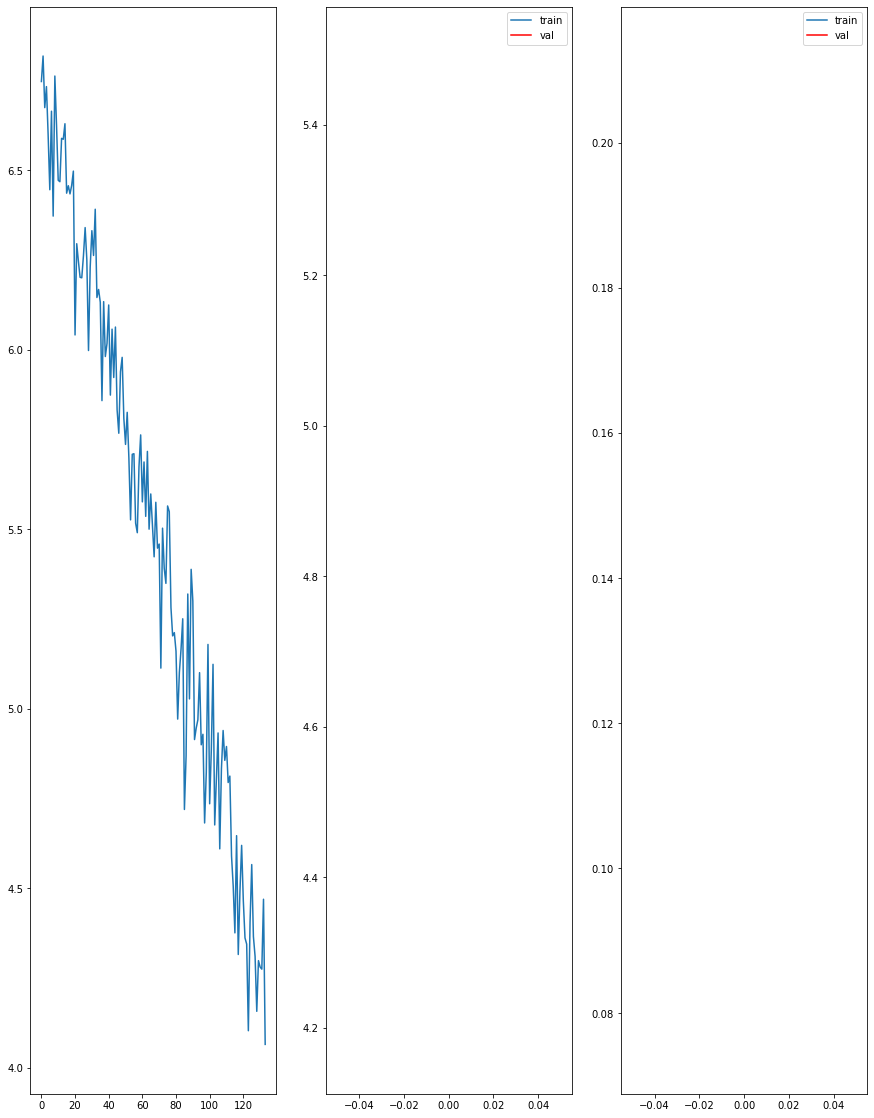

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(3.3581, grad_fn=<NllLossBackward0>)
tensor(3.4077, grad_fn=<NllLossBackward0>)
tensor(3.2882, grad_fn=<NllLossBackward0>)
tensor(3.4562, grad_fn=<NllLossBackward0>)
tensor(3.4603, grad_fn=<NllLossBackward0>)
tensor(3.5715, grad_fn=<NllLossBackward0>)
tensor(3.2749, grad_fn=<NllLossBackward0>)
tensor(3.5589, grad_fn=<NllLossBackward0>)
tensor(3.5818, grad_fn=<NllLossBackward0>)
tensor(3.5193, grad_fn=<NllLossBackward0>)
tensor(3.5920, grad_fn=<NllLossBackward0>)
tensor(3.3621, grad_fn=<NllLossBackward0>)
tensor(3.2724, grad_fn=<NllLossBackward0>)
tensor(3.2157, grad_fn=<NllLossBackward0>)
tensor(3.6837, grad_fn=<NllLossBackward0>)
tensor(3.2114, grad_fn=<NllLossBackward0>)
tensor(3.6055, grad_fn=<NllLossBackward0>)
tensor(3.2718, grad_fn=<NllLossBackward0>)
tensor(3.3131, grad_fn=<NllLossBackward0>)
tensor(3.5069, grad_fn=<NllLossBackward0>)
tensor(3.2512, grad_fn=<NllLossBackward0>)
tensor(3.2500, grad_fn=<NllLossBackward0>)
tensor(3.2292, grad_fn=<NllLossBackward0>)
tensor(2.93

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1	 \Training Loss: 2.979993547966231	     Validation Loss:2.8064550956090293	 \LR:0.0001	     accuracy_trin: 0.43984082341194153	 ccuracy_val: 0.4361022412776947


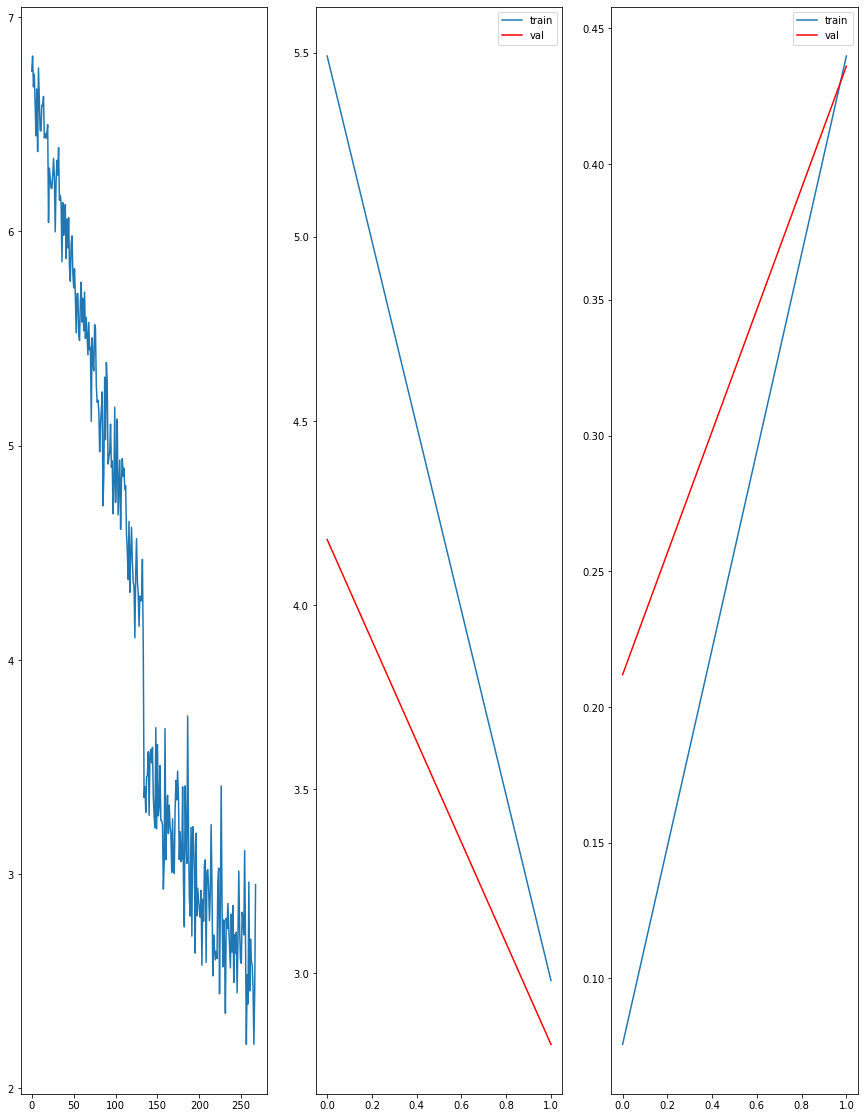

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(1.7359, grad_fn=<NllLossBackward0>)
tensor(1.7605, grad_fn=<NllLossBackward0>)
tensor(1.7335, grad_fn=<NllLossBackward0>)
tensor(1.8436, grad_fn=<NllLossBackward0>)
tensor(1.8744, grad_fn=<NllLossBackward0>)
tensor(1.7083, grad_fn=<NllLossBackward0>)
tensor(1.8175, grad_fn=<NllLossBackward0>)
tensor(1.6037, grad_fn=<NllLossBackward0>)
tensor(1.8283, grad_fn=<NllLossBackward0>)
tensor(2.2211, grad_fn=<NllLossBackward0>)
tensor(1.7207, grad_fn=<NllLossBackward0>)
tensor(1.8226, grad_fn=<NllLossBackward0>)
tensor(1.9010, grad_fn=<NllLossBackward0>)
tensor(1.7309, grad_fn=<NllLossBackward0>)
tensor(1.7945, grad_fn=<NllLossBackward0>)
tensor(1.3762, grad_fn=<NllLossBackward0>)
tensor(1.8866, grad_fn=<NllLossBackward0>)
tensor(1.6713, grad_fn=<NllLossBackward0>)
tensor(1.7778, grad_fn=<NllLossBackward0>)
tensor(1.6469, grad_fn=<NllLossBackward0>)
tensor(1.7678, grad_fn=<NllLossBackward0>)
tensor(1.6369, grad_fn=<NllLossBackward0>)
tensor(1.7757, grad_fn=<NllLossBackward0>)
tensor(1.61

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2	 \Training Loss: 1.5660102563117868	     Validation Loss:2.155276370048523	 \LR:0.0001	     accuracy_trin: 0.7419241666793823	 ccuracy_val: 0.5559105277061462


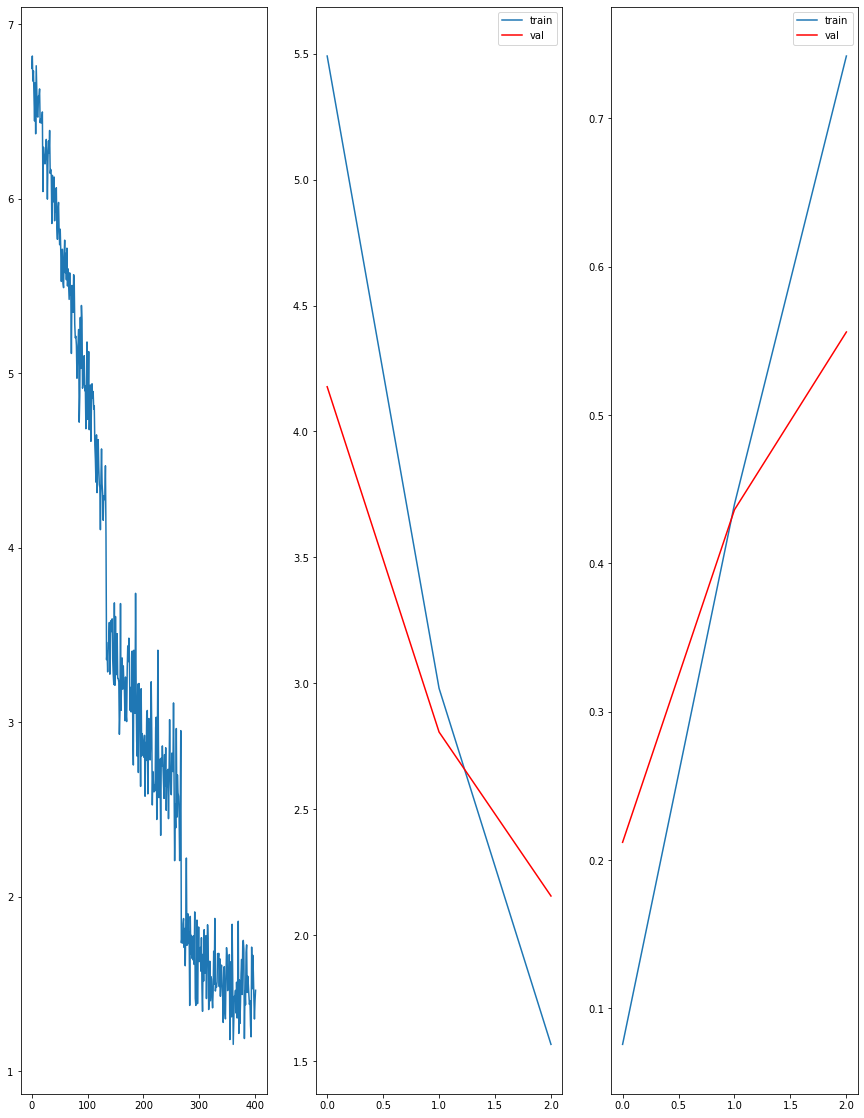

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.6547, grad_fn=<NllLossBackward0>)
tensor(0.9003, grad_fn=<NllLossBackward0>)
tensor(0.8716, grad_fn=<NllLossBackward0>)
tensor(0.8308, grad_fn=<NllLossBackward0>)
tensor(0.8050, grad_fn=<NllLossBackward0>)
tensor(1.1189, grad_fn=<NllLossBackward0>)
tensor(0.7838, grad_fn=<NllLossBackward0>)
tensor(1.0069, grad_fn=<NllLossBackward0>)
tensor(0.7544, grad_fn=<NllLossBackward0>)
tensor(0.7580, grad_fn=<NllLossBackward0>)
tensor(0.7801, grad_fn=<NllLossBackward0>)
tensor(0.7129, grad_fn=<NllLossBackward0>)
tensor(0.7107, grad_fn=<NllLossBackward0>)
tensor(0.6838, grad_fn=<NllLossBackward0>)
tensor(0.8070, grad_fn=<NllLossBackward0>)
tensor(0.6659, grad_fn=<NllLossBackward0>)
tensor(0.6866, grad_fn=<NllLossBackward0>)
tensor(0.9172, grad_fn=<NllLossBackward0>)
tensor(0.8267, grad_fn=<NllLossBackward0>)
tensor(0.8546, grad_fn=<NllLossBackward0>)
tensor(0.6614, grad_fn=<NllLossBackward0>)
tensor(0.9460, grad_fn=<NllLossBackward0>)
tensor(0.8645, grad_fn=<NllLossBackward0>)
tensor(0.75

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3	 \Training Loss: 0.7785340064941947	     Validation Loss:1.856843070189158	 \LR:0.0001	     accuracy_trin: 0.8950140476226807	 ccuracy_val: 0.601703941822052


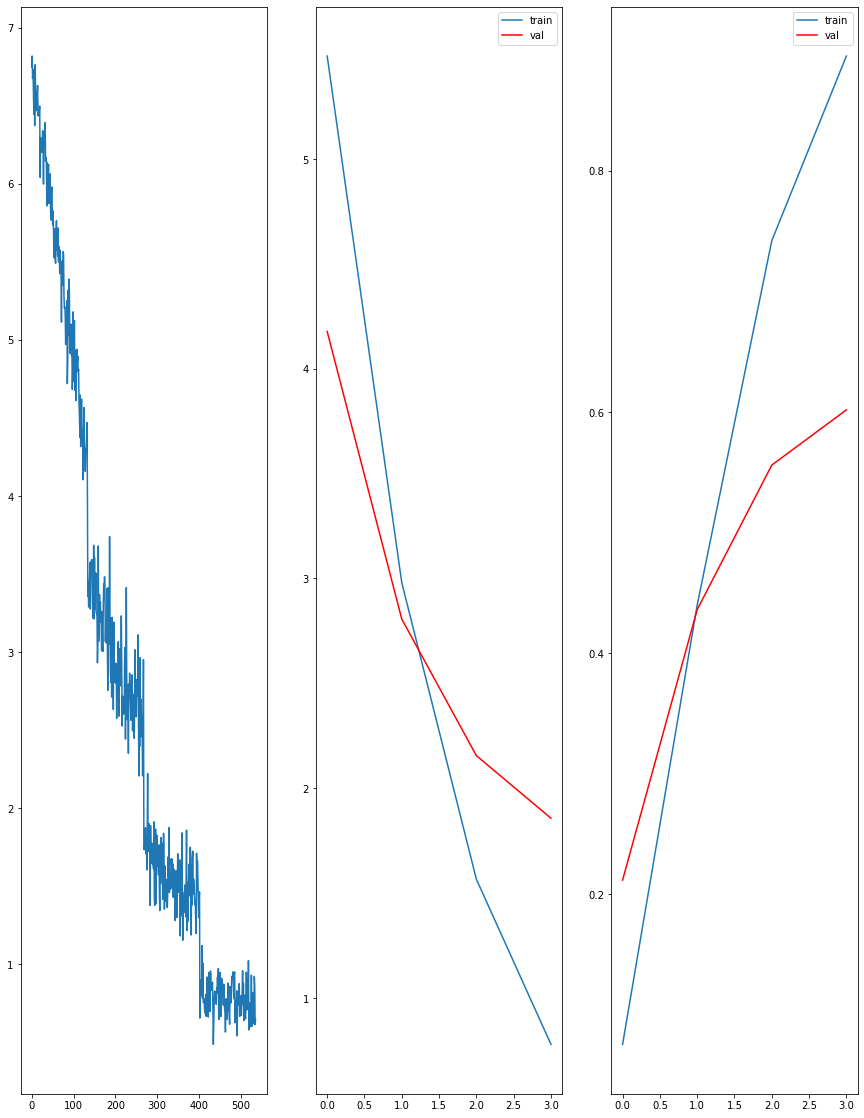

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.4589, grad_fn=<NllLossBackward0>)
tensor(0.2703, grad_fn=<NllLossBackward0>)
tensor(0.4412, grad_fn=<NllLossBackward0>)
tensor(0.3023, grad_fn=<NllLossBackward0>)
tensor(0.2246, grad_fn=<NllLossBackward0>)
tensor(0.4450, grad_fn=<NllLossBackward0>)
tensor(0.2782, grad_fn=<NllLossBackward0>)
tensor(0.2957, grad_fn=<NllLossBackward0>)
tensor(0.3258, grad_fn=<NllLossBackward0>)
tensor(0.3786, grad_fn=<NllLossBackward0>)
tensor(0.3312, grad_fn=<NllLossBackward0>)
tensor(0.4319, grad_fn=<NllLossBackward0>)
tensor(0.2796, grad_fn=<NllLossBackward0>)
tensor(0.5231, grad_fn=<NllLossBackward0>)
tensor(0.4373, grad_fn=<NllLossBackward0>)
tensor(0.3440, grad_fn=<NllLossBackward0>)
tensor(0.2912, grad_fn=<NllLossBackward0>)
tensor(0.3697, grad_fn=<NllLossBackward0>)
tensor(0.3271, grad_fn=<NllLossBackward0>)
tensor(0.4749, grad_fn=<NllLossBackward0>)
tensor(0.4952, grad_fn=<NllLossBackward0>)
tensor(0.4080, grad_fn=<NllLossBackward0>)
tensor(0.4338, grad_fn=<NllLossBackward0>)
tensor(0.36

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4	 \Training Loss: 0.3634620562418183	     Validation Loss:1.6892434716224671	 \LR:0.0001	     accuracy_trin: 0.9643024206161499	 ccuracy_val: 0.6379126906394958


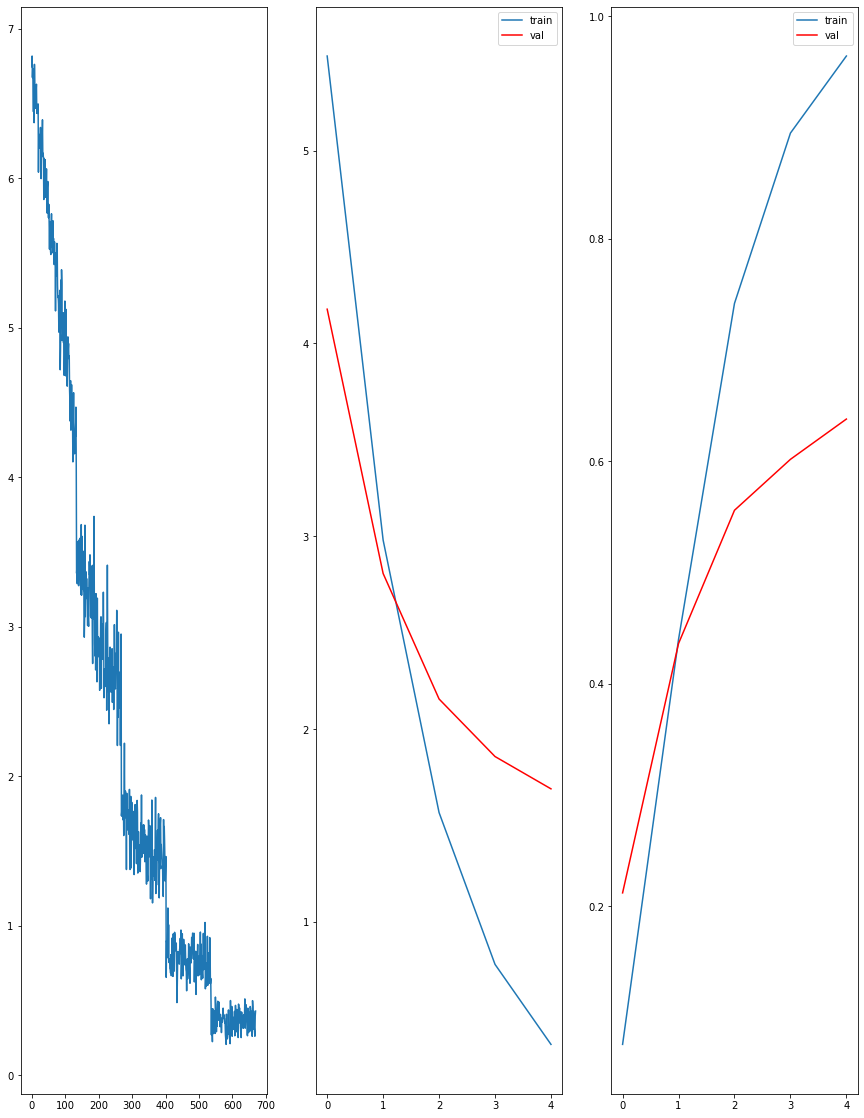

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.1521, grad_fn=<NllLossBackward0>)
tensor(0.2318, grad_fn=<NllLossBackward0>)
tensor(0.1531, grad_fn=<NllLossBackward0>)
tensor(0.1448, grad_fn=<NllLossBackward0>)
tensor(0.1454, grad_fn=<NllLossBackward0>)
tensor(0.2054, grad_fn=<NllLossBackward0>)
tensor(0.1900, grad_fn=<NllLossBackward0>)
tensor(0.1633, grad_fn=<NllLossBackward0>)
tensor(0.1787, grad_fn=<NllLossBackward0>)
tensor(0.2604, grad_fn=<NllLossBackward0>)
tensor(0.1954, grad_fn=<NllLossBackward0>)
tensor(0.1623, grad_fn=<NllLossBackward0>)
tensor(0.2782, grad_fn=<NllLossBackward0>)
tensor(0.1319, grad_fn=<NllLossBackward0>)
tensor(0.2093, grad_fn=<NllLossBackward0>)
tensor(0.1779, grad_fn=<NllLossBackward0>)
tensor(0.1901, grad_fn=<NllLossBackward0>)
tensor(0.1193, grad_fn=<NllLossBackward0>)
tensor(0.2109, grad_fn=<NllLossBackward0>)
tensor(0.1612, grad_fn=<NllLossBackward0>)
tensor(0.1768, grad_fn=<NllLossBackward0>)
tensor(0.2289, grad_fn=<NllLossBackward0>)
tensor(0.1222, grad_fn=<NllLossBackward0>)
tensor(0.21

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5	 \Training Loss: 0.17806560818606348	     Validation Loss:1.5738946239153544	 \LR:0.0001	     accuracy_trin: 0.9888811111450195	 ccuracy_val: 0.6485623121261597


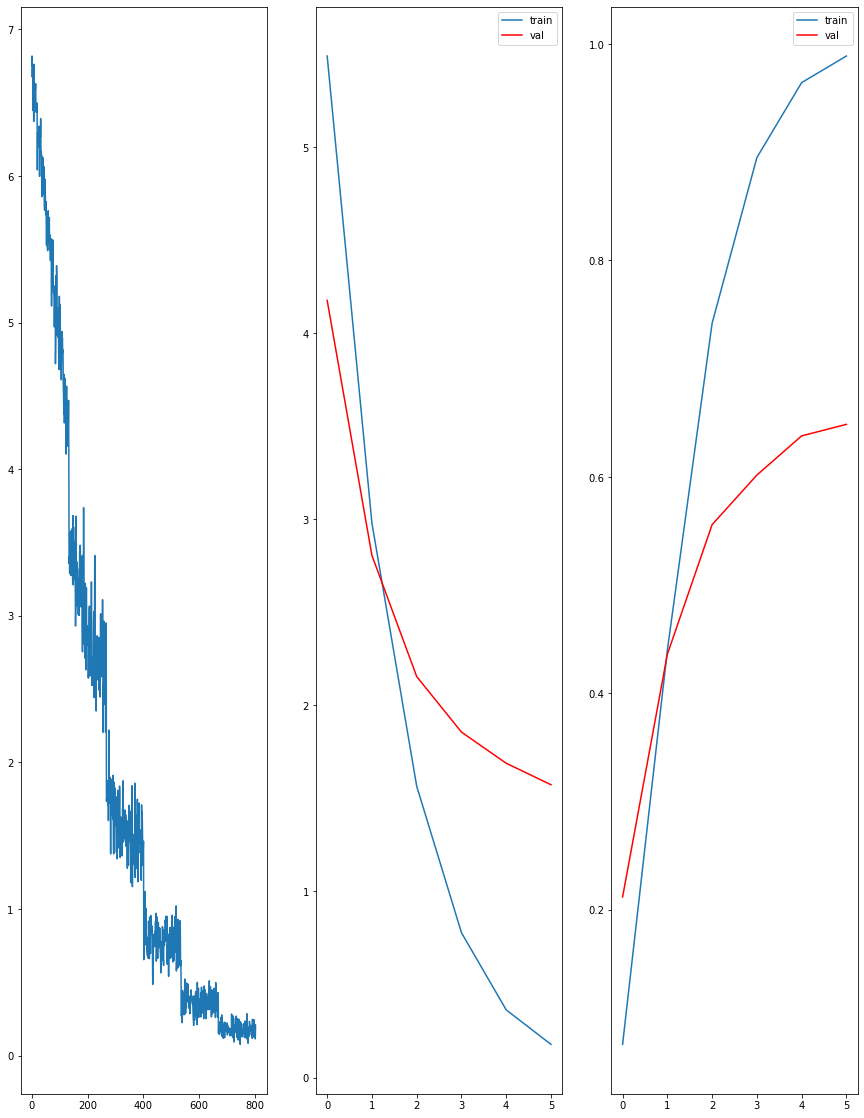

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0780, grad_fn=<NllLossBackward0>)
tensor(0.0917, grad_fn=<NllLossBackward0>)
tensor(0.0712, grad_fn=<NllLossBackward0>)
tensor(0.0863, grad_fn=<NllLossBackward0>)
tensor(0.0822, grad_fn=<NllLossBackward0>)
tensor(0.0629, grad_fn=<NllLossBackward0>)
tensor(0.1277, grad_fn=<NllLossBackward0>)
tensor(0.0718, grad_fn=<NllLossBackward0>)
tensor(0.0687, grad_fn=<NllLossBackward0>)
tensor(0.1437, grad_fn=<NllLossBackward0>)
tensor(0.0693, grad_fn=<NllLossBackward0>)
tensor(0.0760, grad_fn=<NllLossBackward0>)
tensor(0.1017, grad_fn=<NllLossBackward0>)
tensor(0.1419, grad_fn=<NllLossBackward0>)
tensor(0.0789, grad_fn=<NllLossBackward0>)
tensor(0.0860, grad_fn=<NllLossBackward0>)
tensor(0.0964, grad_fn=<NllLossBackward0>)
tensor(0.1076, grad_fn=<NllLossBackward0>)
tensor(0.0760, grad_fn=<NllLossBackward0>)
tensor(0.1126, grad_fn=<NllLossBackward0>)
tensor(0.1100, grad_fn=<NllLossBackward0>)
tensor(0.1020, grad_fn=<NllLossBackward0>)
tensor(0.0757, grad_fn=<NllLossBackward0>)
tensor(0.06

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6	 \Training Loss: 0.09655969831814516	     Validation Loss:1.5206311146418254	 \LR:0.0001	     accuracy_trin: 0.9960206151008606	 ccuracy_val: 0.659744381904602


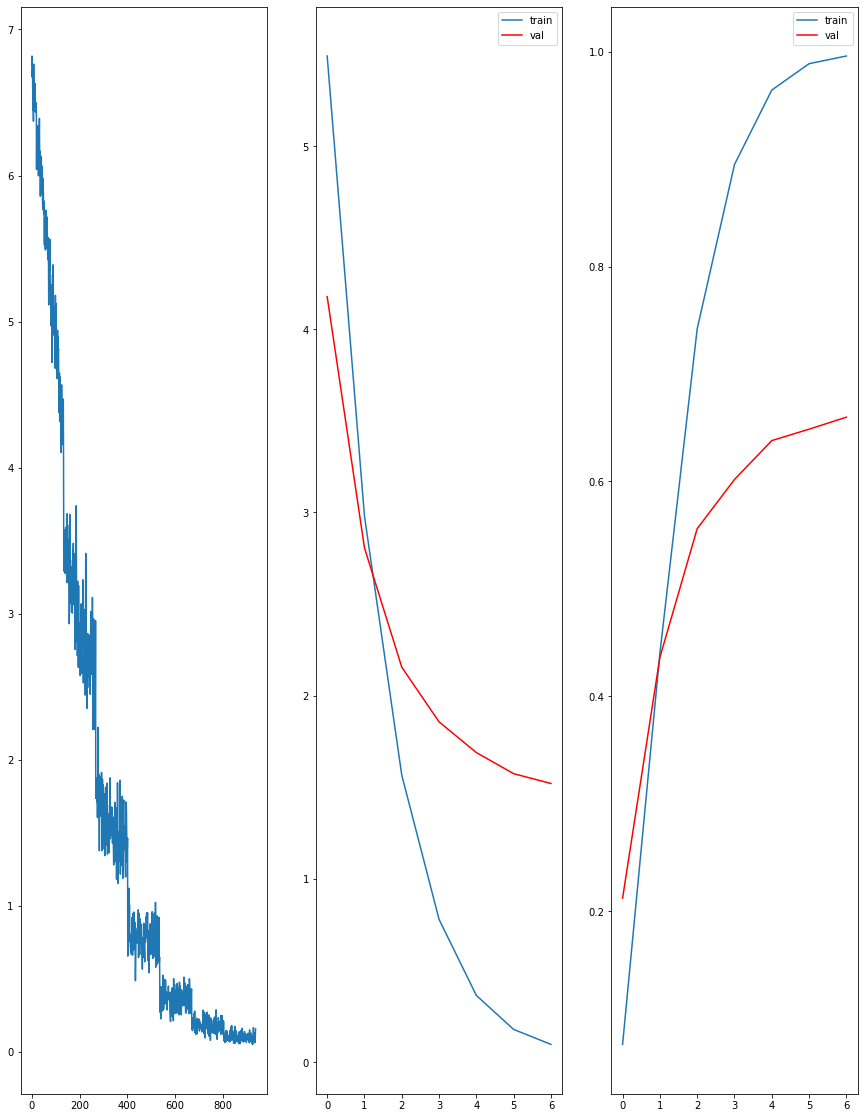

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0547, grad_fn=<NllLossBackward0>)
tensor(0.0754, grad_fn=<NllLossBackward0>)
tensor(0.0586, grad_fn=<NllLossBackward0>)
tensor(0.1083, grad_fn=<NllLossBackward0>)
tensor(0.0545, grad_fn=<NllLossBackward0>)
tensor(0.0509, grad_fn=<NllLossBackward0>)
tensor(0.0358, grad_fn=<NllLossBackward0>)
tensor(0.0719, grad_fn=<NllLossBackward0>)
tensor(0.0442, grad_fn=<NllLossBackward0>)
tensor(0.0694, grad_fn=<NllLossBackward0>)
tensor(0.0416, grad_fn=<NllLossBackward0>)
tensor(0.0951, grad_fn=<NllLossBackward0>)
tensor(0.0413, grad_fn=<NllLossBackward0>)
tensor(0.0684, grad_fn=<NllLossBackward0>)
tensor(0.0898, grad_fn=<NllLossBackward0>)
tensor(0.0426, grad_fn=<NllLossBackward0>)
tensor(0.0581, grad_fn=<NllLossBackward0>)
tensor(0.0546, grad_fn=<NllLossBackward0>)
tensor(0.0395, grad_fn=<NllLossBackward0>)
tensor(0.0571, grad_fn=<NllLossBackward0>)
tensor(0.0481, grad_fn=<NllLossBackward0>)
tensor(0.0489, grad_fn=<NllLossBackward0>)
tensor(0.0950, grad_fn=<NllLossBackward0>)
tensor(0.05

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7	 \Training Loss: 0.059553921000281375	     Validation Loss:1.4831498344739278	 \LR:0.0001	     accuracy_trin: 0.9970739483833313	 ccuracy_val: 0.664536714553833


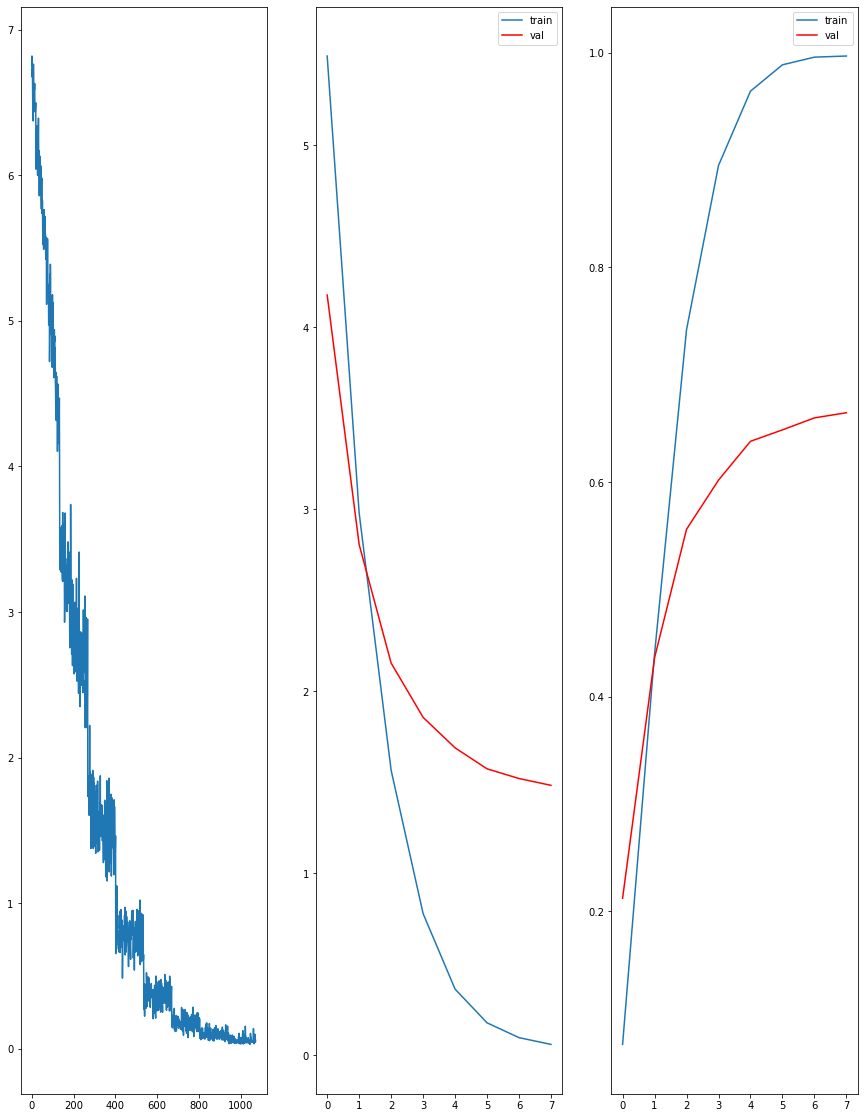

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0282, grad_fn=<NllLossBackward0>)
tensor(0.0361, grad_fn=<NllLossBackward0>)
tensor(0.0301, grad_fn=<NllLossBackward0>)
tensor(0.0295, grad_fn=<NllLossBackward0>)
tensor(0.0292, grad_fn=<NllLossBackward0>)
tensor(0.0675, grad_fn=<NllLossBackward0>)
tensor(0.0548, grad_fn=<NllLossBackward0>)
tensor(0.0512, grad_fn=<NllLossBackward0>)
tensor(0.0403, grad_fn=<NllLossBackward0>)
tensor(0.0269, grad_fn=<NllLossBackward0>)
tensor(0.0258, grad_fn=<NllLossBackward0>)
tensor(0.0495, grad_fn=<NllLossBackward0>)
tensor(0.0387, grad_fn=<NllLossBackward0>)
tensor(0.0393, grad_fn=<NllLossBackward0>)
tensor(0.0307, grad_fn=<NllLossBackward0>)
tensor(0.0257, grad_fn=<NllLossBackward0>)
tensor(0.0914, grad_fn=<NllLossBackward0>)
tensor(0.0311, grad_fn=<NllLossBackward0>)
tensor(0.0311, grad_fn=<NllLossBackward0>)
tensor(0.0263, grad_fn=<NllLossBackward0>)
tensor(0.0355, grad_fn=<NllLossBackward0>)
tensor(0.0535, grad_fn=<NllLossBackward0>)
tensor(0.0398, grad_fn=<NllLossBackward0>)
tensor(0.02

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8	 \Training Loss: 0.036947626870737146	     Validation Loss:1.4264793316523234	 \LR:0.0001	     accuracy_trin: 0.9987125396728516	 ccuracy_val: 0.6858360171318054


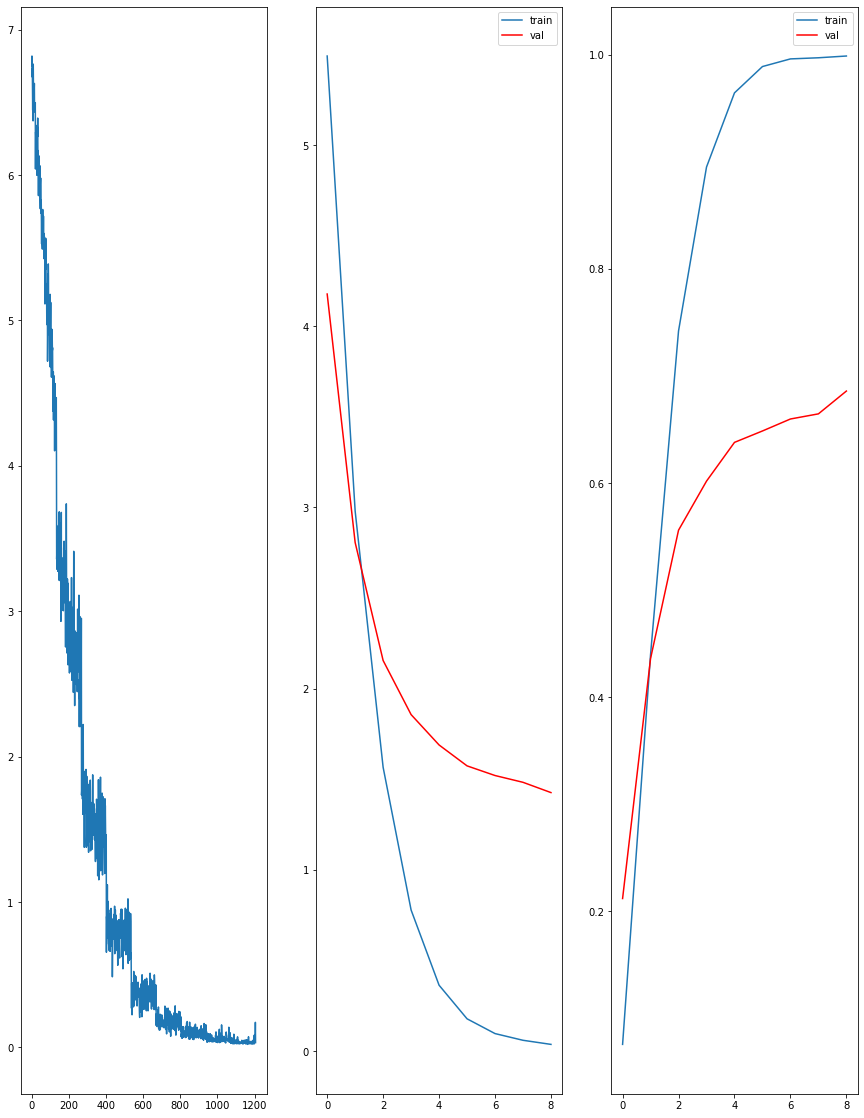

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0228, grad_fn=<NllLossBackward0>)
tensor(0.0797, grad_fn=<NllLossBackward0>)
tensor(0.0312, grad_fn=<NllLossBackward0>)
tensor(0.0175, grad_fn=<NllLossBackward0>)
tensor(0.0337, grad_fn=<NllLossBackward0>)
tensor(0.0214, grad_fn=<NllLossBackward0>)
tensor(0.0214, grad_fn=<NllLossBackward0>)
tensor(0.0244, grad_fn=<NllLossBackward0>)
tensor(0.0362, grad_fn=<NllLossBackward0>)
tensor(0.0281, grad_fn=<NllLossBackward0>)
tensor(0.0292, grad_fn=<NllLossBackward0>)
tensor(0.0228, grad_fn=<NllLossBackward0>)
tensor(0.0277, grad_fn=<NllLossBackward0>)
tensor(0.0256, grad_fn=<NllLossBackward0>)
tensor(0.0245, grad_fn=<NllLossBackward0>)
tensor(0.0256, grad_fn=<NllLossBackward0>)
tensor(0.0196, grad_fn=<NllLossBackward0>)
tensor(0.0311, grad_fn=<NllLossBackward0>)
tensor(0.0222, grad_fn=<NllLossBackward0>)
tensor(0.0214, grad_fn=<NllLossBackward0>)
tensor(0.0213, grad_fn=<NllLossBackward0>)
tensor(0.1294, grad_fn=<NllLossBackward0>)
tensor(0.0221, grad_fn=<NllLossBackward0>)
tensor(0.02

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9	 \Training Loss: 0.028021689469634153	     Validation Loss:1.4171550790468852	 \LR:0.0001	     accuracy_trin: 0.9994148015975952	 ccuracy_val: 0.6810436844825745


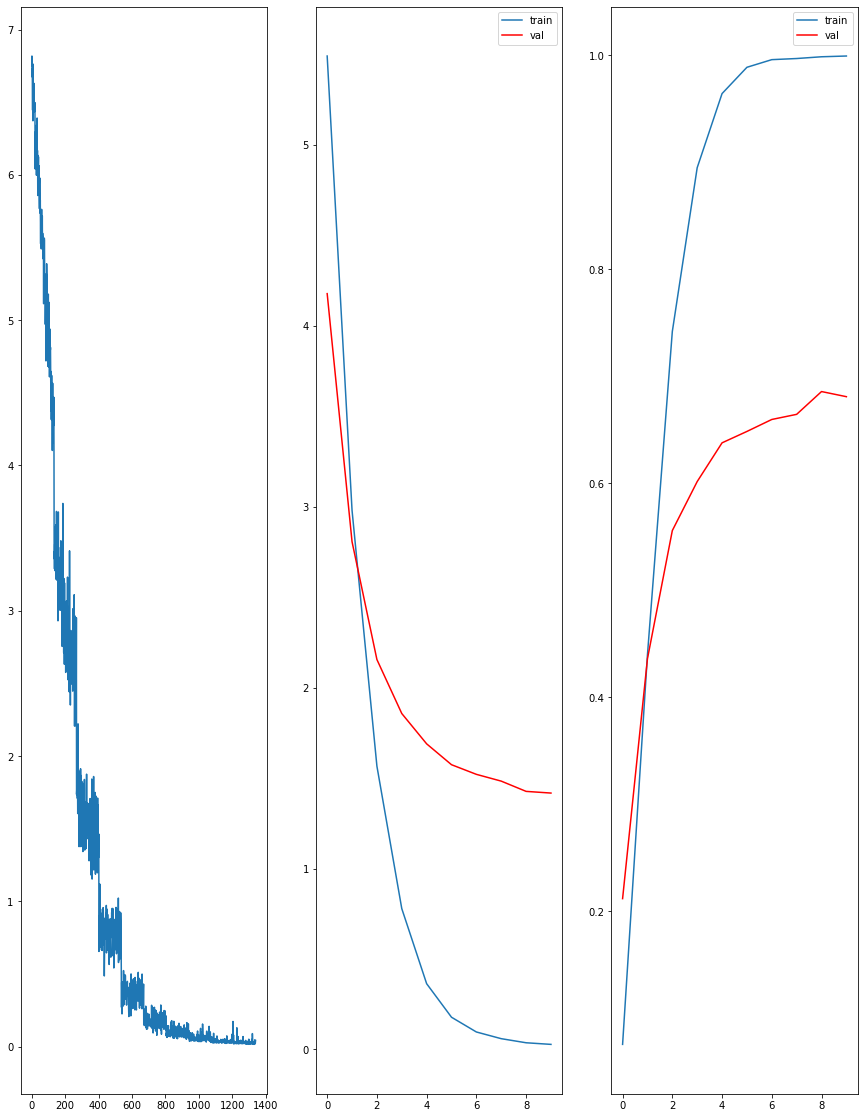

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0162, grad_fn=<NllLossBackward0>)
tensor(0.0221, grad_fn=<NllLossBackward0>)
tensor(0.0161, grad_fn=<NllLossBackward0>)
tensor(0.0148, grad_fn=<NllLossBackward0>)
tensor(0.0241, grad_fn=<NllLossBackward0>)
tensor(0.0180, grad_fn=<NllLossBackward0>)
tensor(0.0152, grad_fn=<NllLossBackward0>)
tensor(0.0164, grad_fn=<NllLossBackward0>)
tensor(0.0205, grad_fn=<NllLossBackward0>)
tensor(0.0175, grad_fn=<NllLossBackward0>)
tensor(0.0618, grad_fn=<NllLossBackward0>)
tensor(0.0144, grad_fn=<NllLossBackward0>)
tensor(0.0134, grad_fn=<NllLossBackward0>)
tensor(0.0182, grad_fn=<NllLossBackward0>)
tensor(0.0167, grad_fn=<NllLossBackward0>)
tensor(0.0182, grad_fn=<NllLossBackward0>)
tensor(0.0139, grad_fn=<NllLossBackward0>)
tensor(0.0150, grad_fn=<NllLossBackward0>)
tensor(0.0151, grad_fn=<NllLossBackward0>)
tensor(0.0176, grad_fn=<NllLossBackward0>)
tensor(0.0374, grad_fn=<NllLossBackward0>)
tensor(0.0173, grad_fn=<NllLossBackward0>)
tensor(0.0188, grad_fn=<NllLossBackward0>)
tensor(0.01

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10	 \Training Loss: 0.017548091459407736	     Validation Loss:1.3890539844830831	 \LR:0.0001	     accuracy_trin: 0.999765932559967	 ccuracy_val: 0.6858360171318054


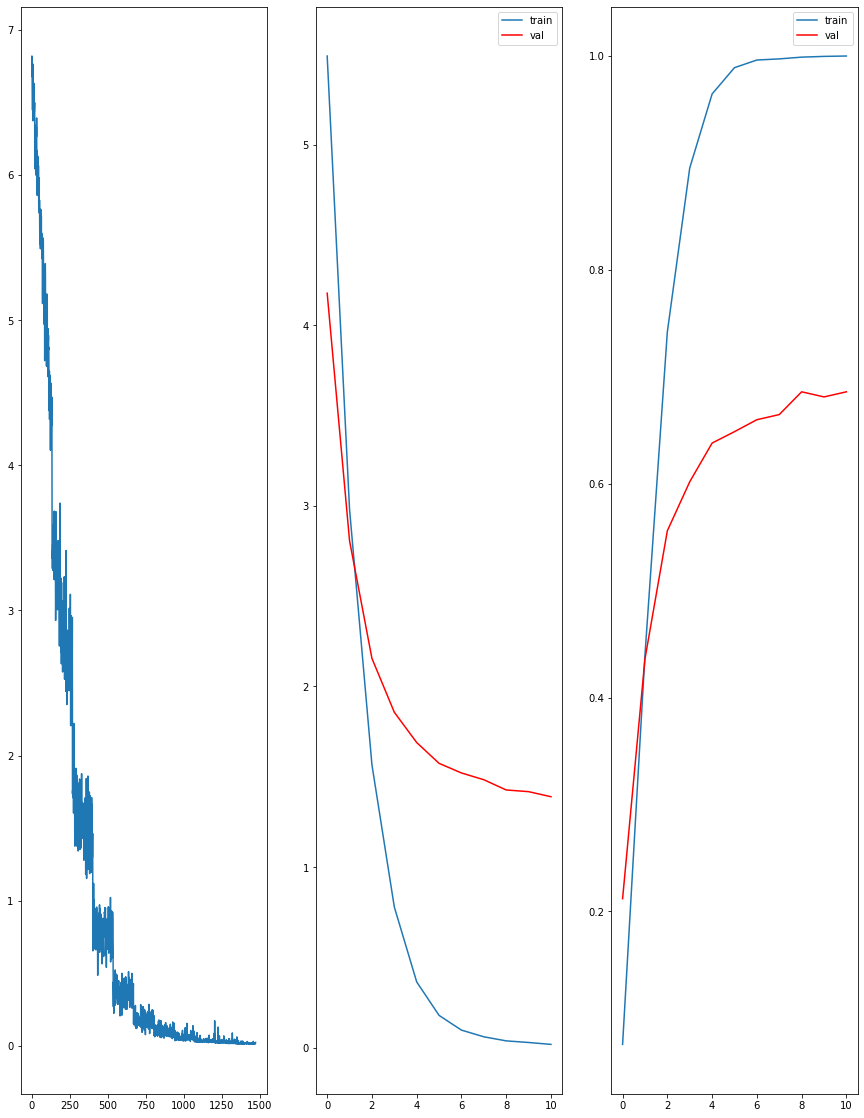

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0129, grad_fn=<NllLossBackward0>)
tensor(0.0153, grad_fn=<NllLossBackward0>)
tensor(0.0126, grad_fn=<NllLossBackward0>)
tensor(0.0144, grad_fn=<NllLossBackward0>)
tensor(0.0133, grad_fn=<NllLossBackward0>)
tensor(0.0120, grad_fn=<NllLossBackward0>)
tensor(0.0129, grad_fn=<NllLossBackward0>)
tensor(0.0149, grad_fn=<NllLossBackward0>)
tensor(0.0126, grad_fn=<NllLossBackward0>)
tensor(0.0130, grad_fn=<NllLossBackward0>)
tensor(0.0150, grad_fn=<NllLossBackward0>)
tensor(0.0110, grad_fn=<NllLossBackward0>)
tensor(0.0200, grad_fn=<NllLossBackward0>)
tensor(0.0116, grad_fn=<NllLossBackward0>)
tensor(0.0127, grad_fn=<NllLossBackward0>)
tensor(0.0121, grad_fn=<NllLossBackward0>)
tensor(0.0121, grad_fn=<NllLossBackward0>)
tensor(0.0122, grad_fn=<NllLossBackward0>)
tensor(0.0202, grad_fn=<NllLossBackward0>)
tensor(0.0125, grad_fn=<NllLossBackward0>)
tensor(0.0100, grad_fn=<NllLossBackward0>)
tensor(0.0165, grad_fn=<NllLossBackward0>)
tensor(0.0113, grad_fn=<NllLossBackward0>)
tensor(0.01

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11	 \Training Loss: 0.013238259035148728	     Validation Loss:1.3608837683995565	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.698615550994873


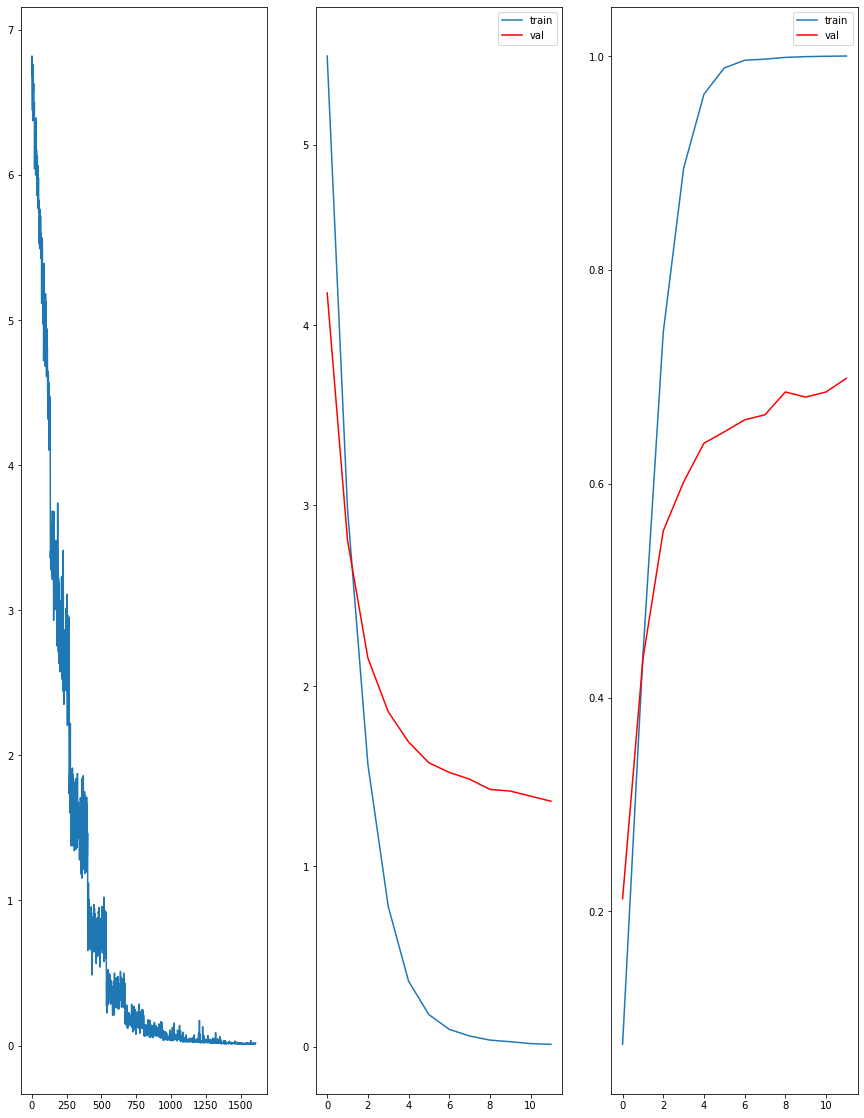

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0095, grad_fn=<NllLossBackward0>)
tensor(0.0105, grad_fn=<NllLossBackward0>)
tensor(0.0102, grad_fn=<NllLossBackward0>)
tensor(0.0139, grad_fn=<NllLossBackward0>)
tensor(0.0104, grad_fn=<NllLossBackward0>)
tensor(0.0091, grad_fn=<NllLossBackward0>)
tensor(0.0133, grad_fn=<NllLossBackward0>)
tensor(0.0118, grad_fn=<NllLossBackward0>)
tensor(0.0113, grad_fn=<NllLossBackward0>)
tensor(0.0154, grad_fn=<NllLossBackward0>)
tensor(0.0083, grad_fn=<NllLossBackward0>)
tensor(0.0257, grad_fn=<NllLossBackward0>)
tensor(0.0101, grad_fn=<NllLossBackward0>)
tensor(0.0113, grad_fn=<NllLossBackward0>)
tensor(0.0120, grad_fn=<NllLossBackward0>)
tensor(0.0098, grad_fn=<NllLossBackward0>)
tensor(0.0108, grad_fn=<NllLossBackward0>)
tensor(0.0100, grad_fn=<NllLossBackward0>)
tensor(0.0095, grad_fn=<NllLossBackward0>)
tensor(0.0102, grad_fn=<NllLossBackward0>)
tensor(0.0102, grad_fn=<NllLossBackward0>)
tensor(0.0098, grad_fn=<NllLossBackward0>)
tensor(0.0125, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12	 \Training Loss: 0.011109098628747151	     Validation Loss:1.3583858549594878	 \LR:0.0001	     accuracy_trin: 0.9998829364776611	 ccuracy_val: 0.6932907104492188


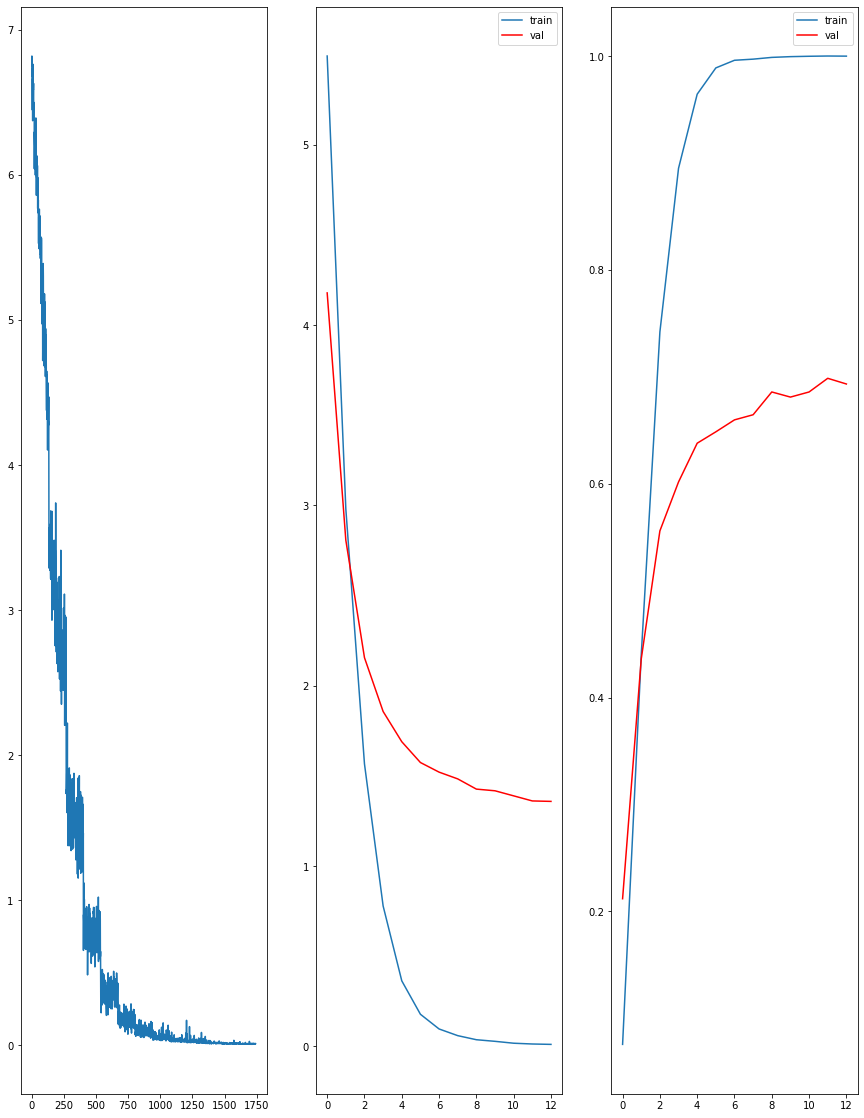

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0103, grad_fn=<NllLossBackward0>)
tensor(0.0082, grad_fn=<NllLossBackward0>)
tensor(0.0077, grad_fn=<NllLossBackward0>)
tensor(0.0086, grad_fn=<NllLossBackward0>)
tensor(0.0083, grad_fn=<NllLossBackward0>)
tensor(0.0095, grad_fn=<NllLossBackward0>)
tensor(0.0086, grad_fn=<NllLossBackward0>)
tensor(0.0079, grad_fn=<NllLossBackward0>)
tensor(0.0088, grad_fn=<NllLossBackward0>)
tensor(0.0072, grad_fn=<NllLossBackward0>)
tensor(0.0092, grad_fn=<NllLossBackward0>)
tensor(0.0096, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.0888, grad_fn=<NllLossBackward0>)
tensor(0.0095, grad_fn=<NllLossBackward0>)
tensor(0.0102, grad_fn=<NllLossBackward0>)
tensor(0.0098, grad_fn=<NllLossBackward0>)
tensor(0.0068, grad_fn=<NllLossBackward0>)
tensor(0.0096, grad_fn=<NllLossBackward0>)
tensor(0.0082, grad_fn=<NllLossBackward0>)
tensor(0.0097, grad_fn=<NllLossBackward0>)
tensor(0.0069, grad_fn=<NllLossBackward0>)
tensor(0.0082, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13	 \Training Loss: 0.009933006122652719	     Validation Loss:1.3575181146462758	 \LR:0.0001	     accuracy_trin: 0.9998829364776611	 ccuracy_val: 0.6959531307220459


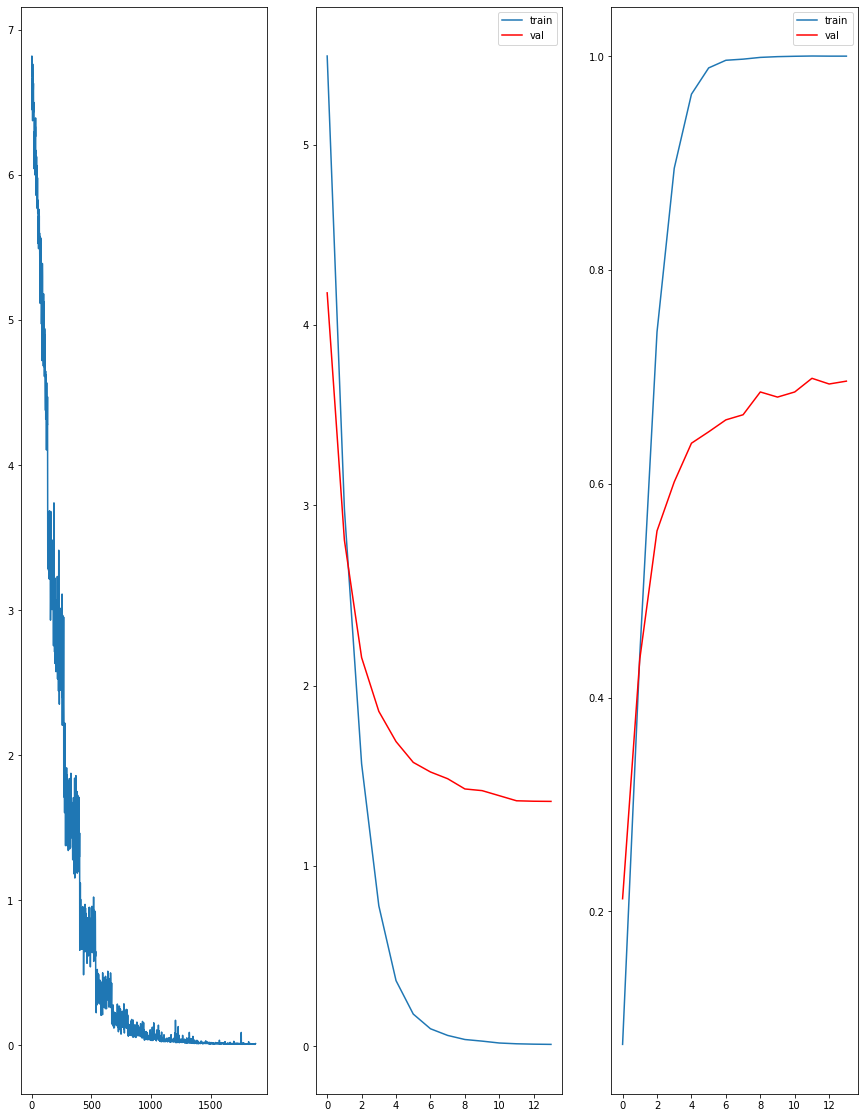

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0078, grad_fn=<NllLossBackward0>)
tensor(0.0080, grad_fn=<NllLossBackward0>)
tensor(0.0069, grad_fn=<NllLossBackward0>)
tensor(0.0128, grad_fn=<NllLossBackward0>)
tensor(0.0098, grad_fn=<NllLossBackward0>)
tensor(0.0067, grad_fn=<NllLossBackward0>)
tensor(0.0077, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.0066, grad_fn=<NllLossBackward0>)
tensor(0.0078, grad_fn=<NllLossBackward0>)
tensor(0.0077, grad_fn=<NllLossBackward0>)
tensor(0.0063, grad_fn=<NllLossBackward0>)
tensor(0.0071, grad_fn=<NllLossBackward0>)
tensor(0.0078, grad_fn=<NllLossBackward0>)
tensor(0.0094, grad_fn=<NllLossBackward0>)
tensor(0.0077, grad_fn=<NllLossBackward0>)
tensor(0.0066, grad_fn=<NllLossBackward0>)
tensor(0.0105, grad_fn=<NllLossBackward0>)
tensor(0.0126, grad_fn=<NllLossBackward0>)
tensor(0.0069, grad_fn=<NllLossBackward0>)
tensor(0.0082, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14	 \Training Loss: 0.008167578168074363	     Validation Loss:1.3551249504089355	 \LR:0.0001	     accuracy_trin: 0.999765932559967	 ccuracy_val: 0.6964856386184692


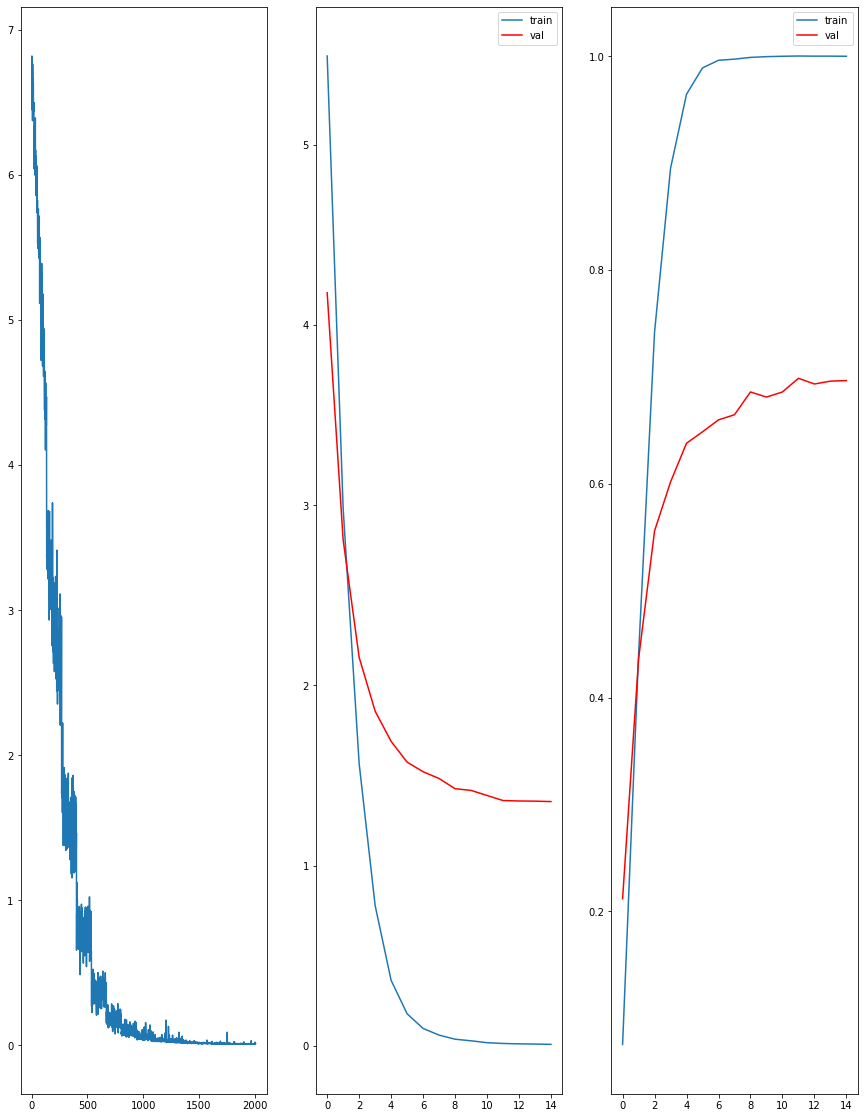

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0057, grad_fn=<NllLossBackward0>)
tensor(0.0061, grad_fn=<NllLossBackward0>)
tensor(0.0068, grad_fn=<NllLossBackward0>)
tensor(0.0062, grad_fn=<NllLossBackward0>)
tensor(0.0074, grad_fn=<NllLossBackward0>)
tensor(0.0050, grad_fn=<NllLossBackward0>)
tensor(0.0078, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0078, grad_fn=<NllLossBackward0>)
tensor(0.0056, grad_fn=<NllLossBackward0>)
tensor(0.0051, grad_fn=<NllLossBackward0>)
tensor(0.0054, grad_fn=<NllLossBackward0>)
tensor(0.0071, grad_fn=<NllLossBackward0>)
tensor(0.0067, grad_fn=<NllLossBackward0>)
tensor(0.0057, grad_fn=<NllLossBackward0>)
tensor(0.0067, grad_fn=<NllLossBackward0>)
tensor(0.0063, grad_fn=<NllLossBackward0>)
tensor(0.0061, grad_fn=<NllLossBackward0>)
tensor(0.0067, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0068, grad_fn=<NllLossBackward0>)
tensor(0.0230, grad_fn=<NllLossBackward0>)
tensor(0.0084, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15	 \Training Loss: 0.006704859209677844	     Validation Loss:1.3512518584728241	 \LR:0.0001	     accuracy_trin: 0.9998829364776611	 ccuracy_val: 0.6927582621574402


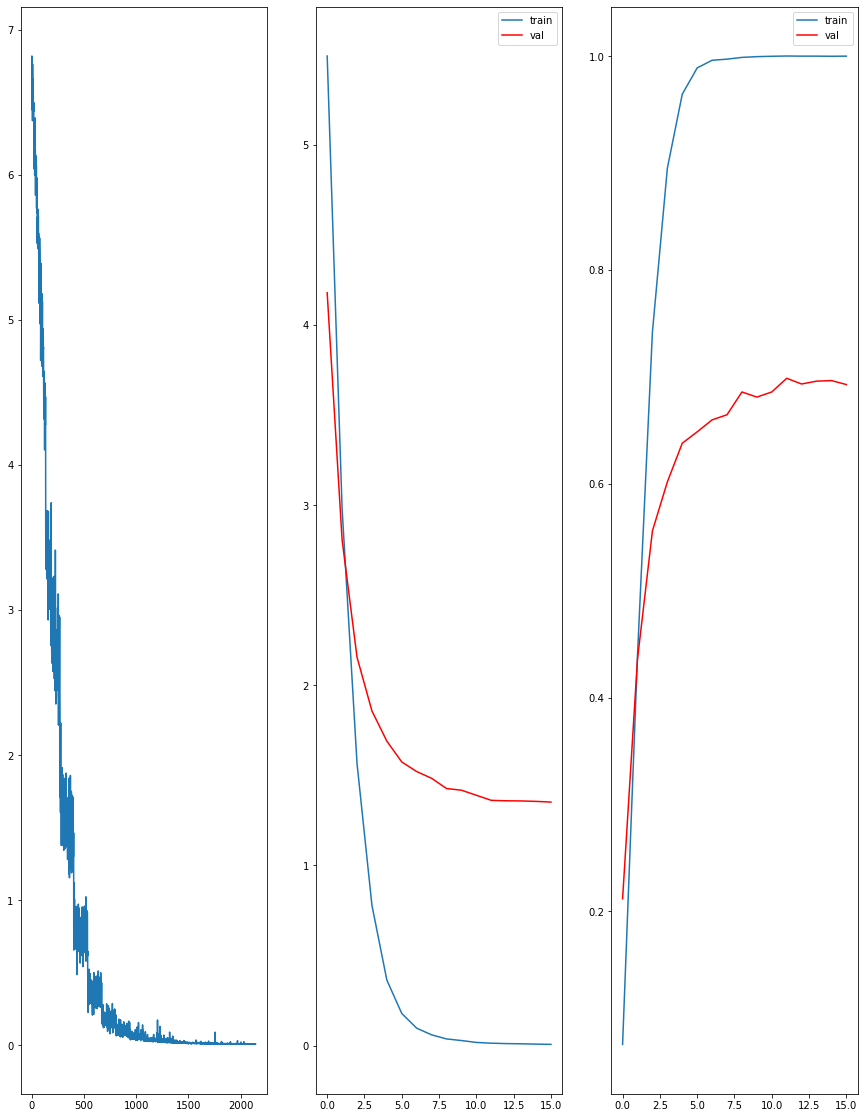

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0050, grad_fn=<NllLossBackward0>)
tensor(0.0060, grad_fn=<NllLossBackward0>)
tensor(0.0046, grad_fn=<NllLossBackward0>)
tensor(0.0052, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0051, grad_fn=<NllLossBackward0>)
tensor(0.0052, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0054, grad_fn=<NllLossBackward0>)
tensor(0.0043, grad_fn=<NllLossBackward0>)
tensor(0.0069, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0070, grad_fn=<NllLossBackward0>)
tensor(0.0047, grad_fn=<NllLossBackward0>)
tensor(0.0059, grad_fn=<NllLossBackward0>)
tensor(0.0050, grad_fn=<NllLossBackward0>)
tensor(0.0054, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16	 \Training Loss: 0.00553002534955462	     Validation Loss:1.3413322905699412	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.6970180869102478


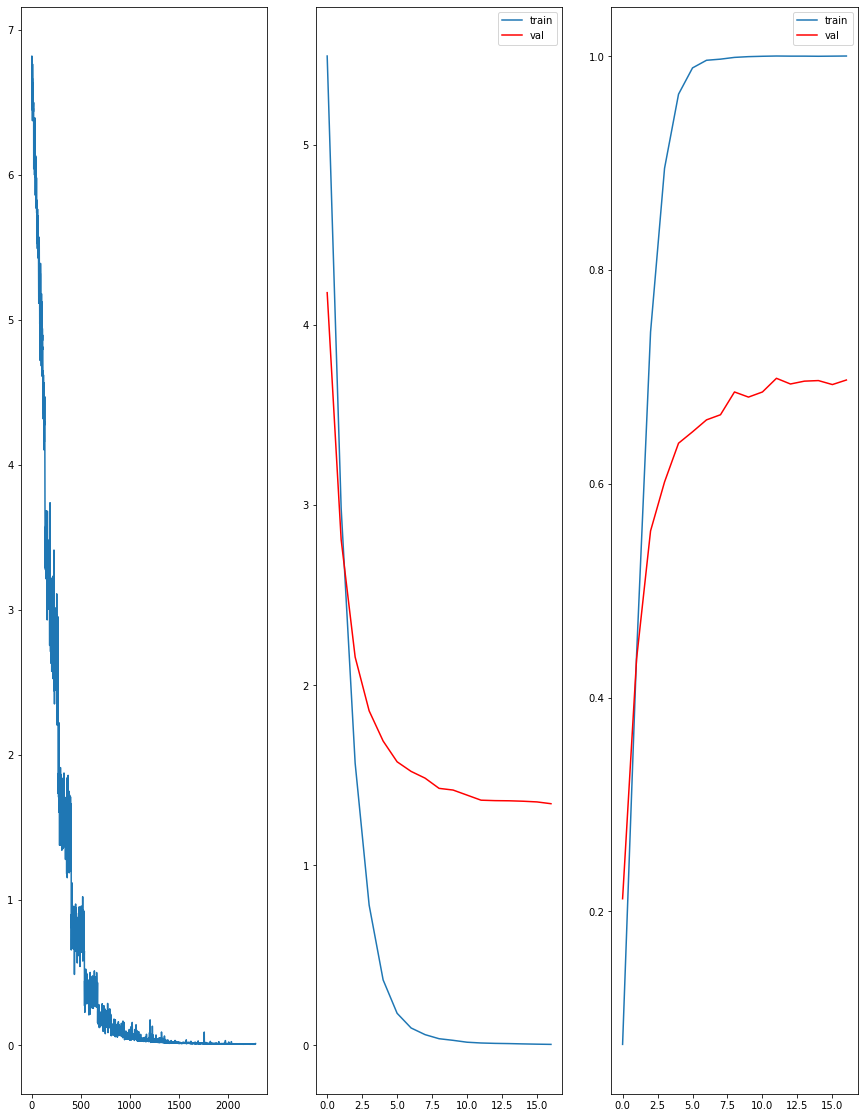

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0051, grad_fn=<NllLossBackward0>)
tensor(0.0049, grad_fn=<NllLossBackward0>)
tensor(0.0058, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.0044, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0050, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.0051, grad_fn=<NllLossBackward0>)
tensor(0.0049, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0047, grad_fn=<NllLossBackward0>)
tensor(0.0047, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0058, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0081, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17	 \Training Loss: 0.004986025514637134	     Validation Loss:1.3357545952002208	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.6954206824302673


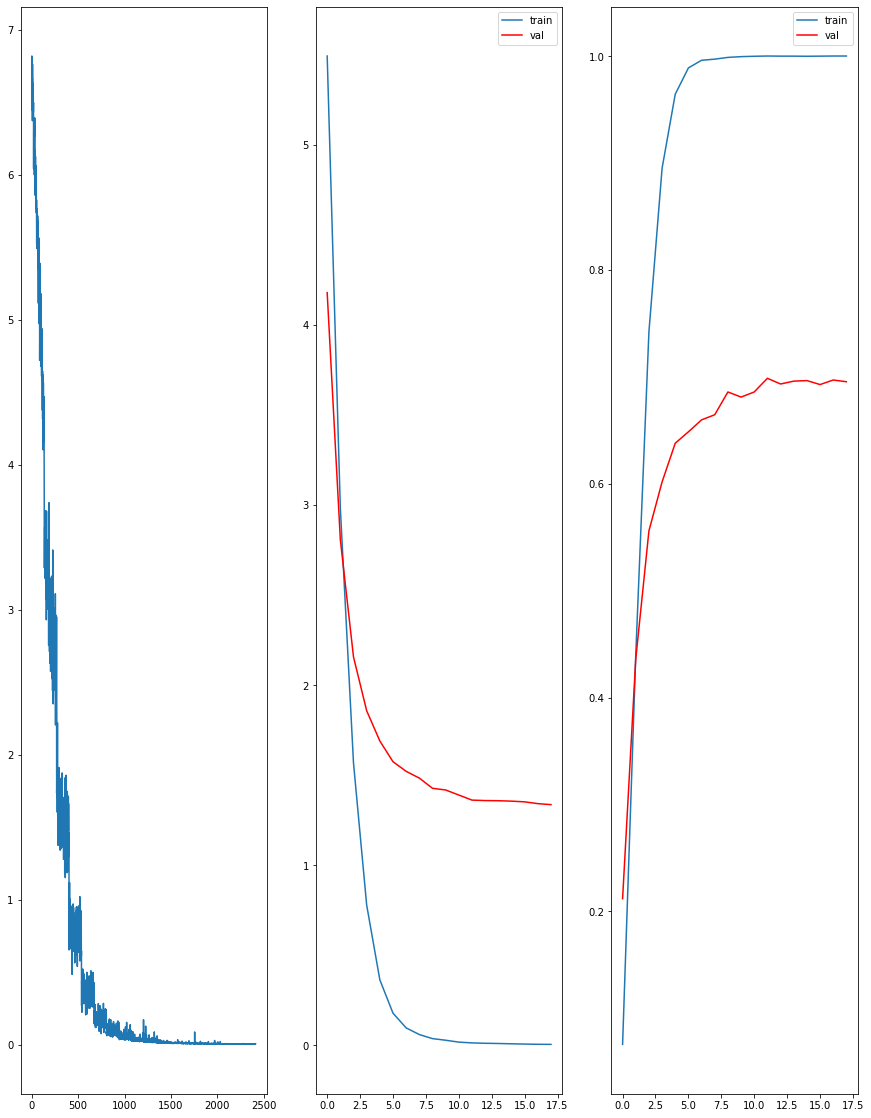

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0050, grad_fn=<NllLossBackward0>)
tensor(0.0049, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0044, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0043, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.0044, grad_fn=<NllLossBackward0>)
tensor(0.0047, grad_fn=<NllLossBackward0>)
tensor(0.0043, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0049, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0038, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18	 \Training Loss: 0.004392874194309115	     Validation Loss:1.3316006243228913	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.6970180869102478


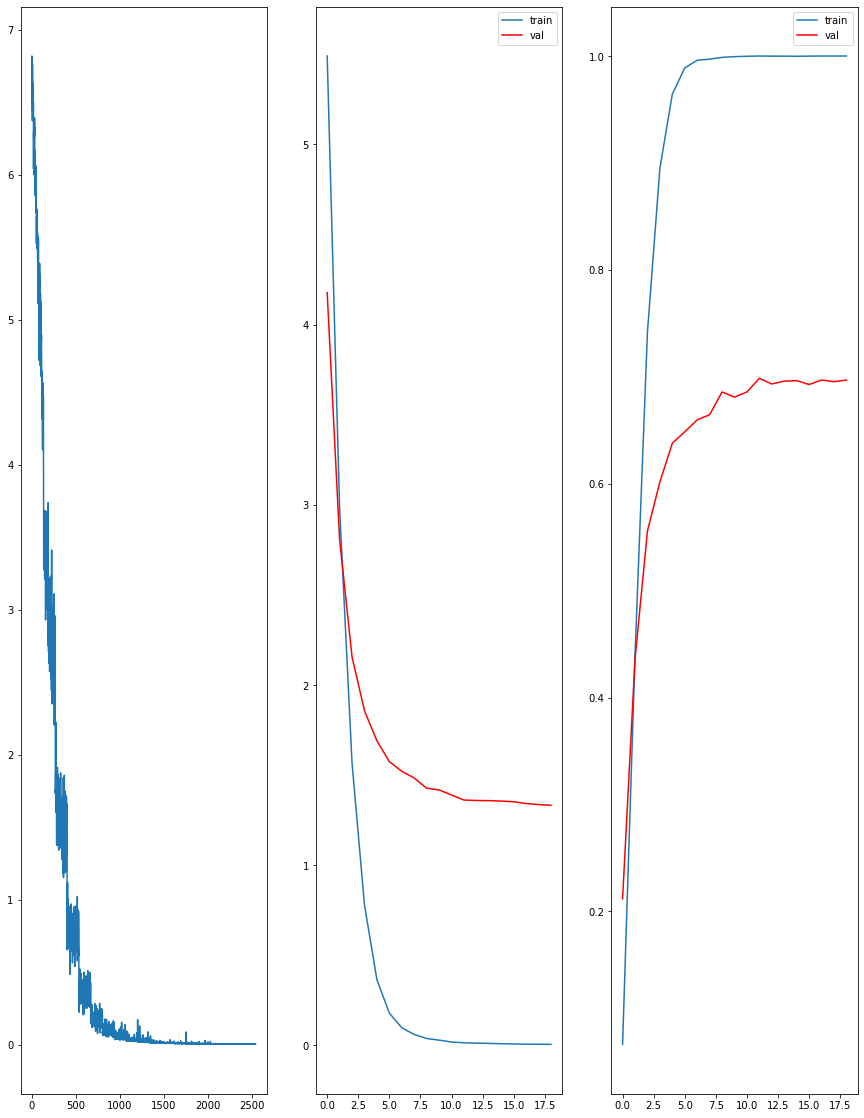

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0038, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0043, grad_fn=<NllLossBackward0>)
tensor(0.0038, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0050, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0038, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19	 \Training Loss: 0.0038515594909523626	     Validation Loss:1.3289400577545165	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.699680507183075


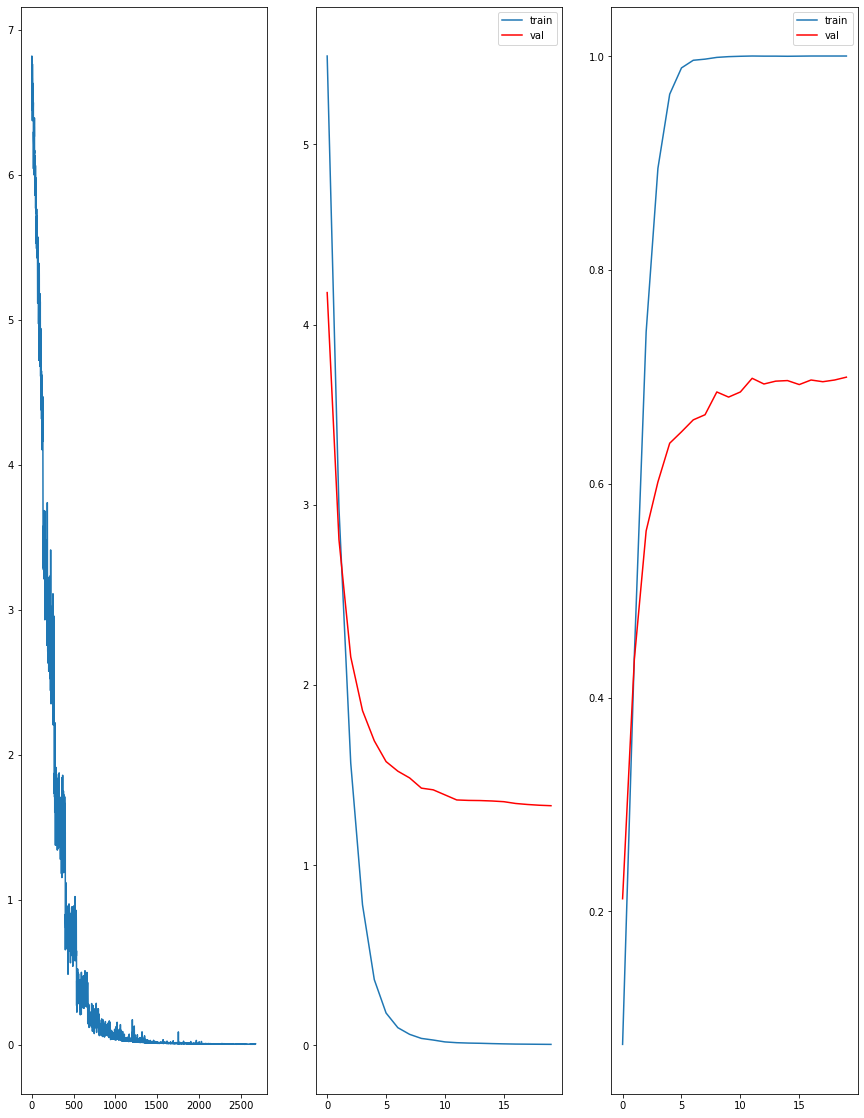

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0038, grad_fn=<NllLossBackward0>)
tensor(0.0031, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0031, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20	 \Training Loss: 0.003417781189278658	     Validation Loss:1.3298423806826274	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7002130150794983


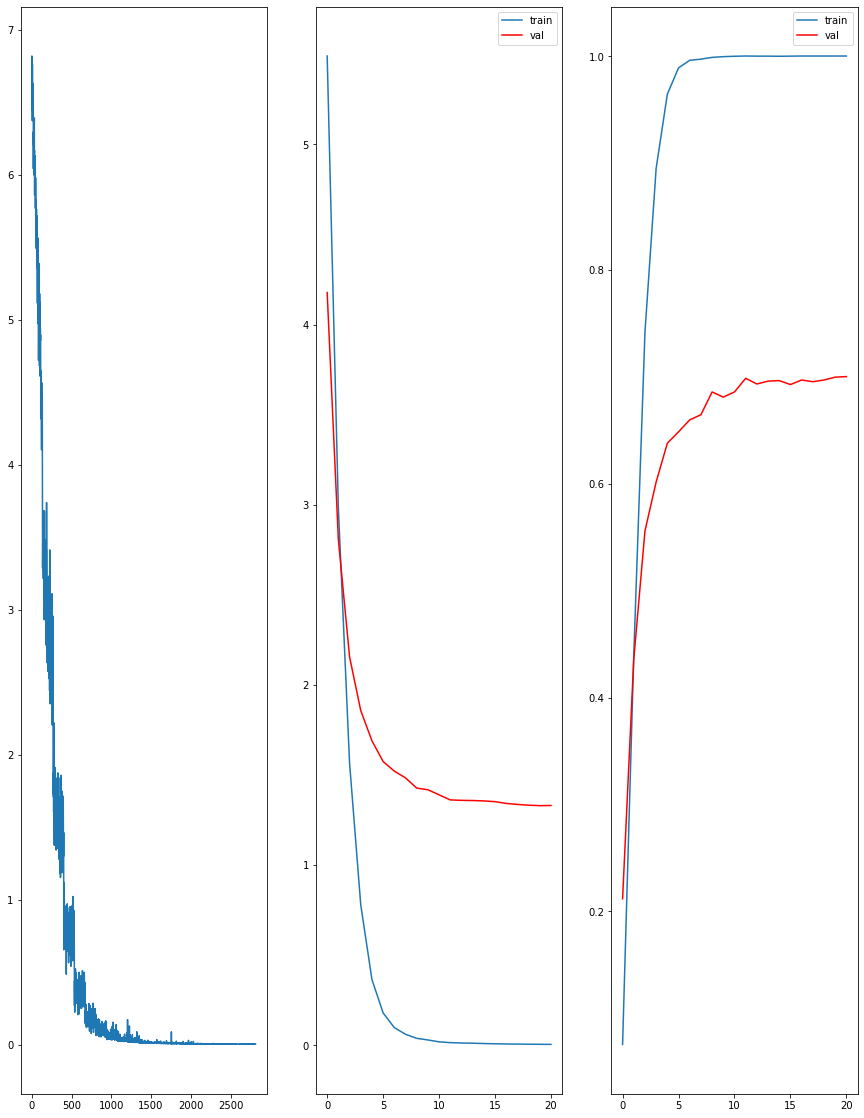

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0043, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21	 \Training Loss: 0.0030328055979239182	     Validation Loss:1.3289382994174956	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.694888174533844


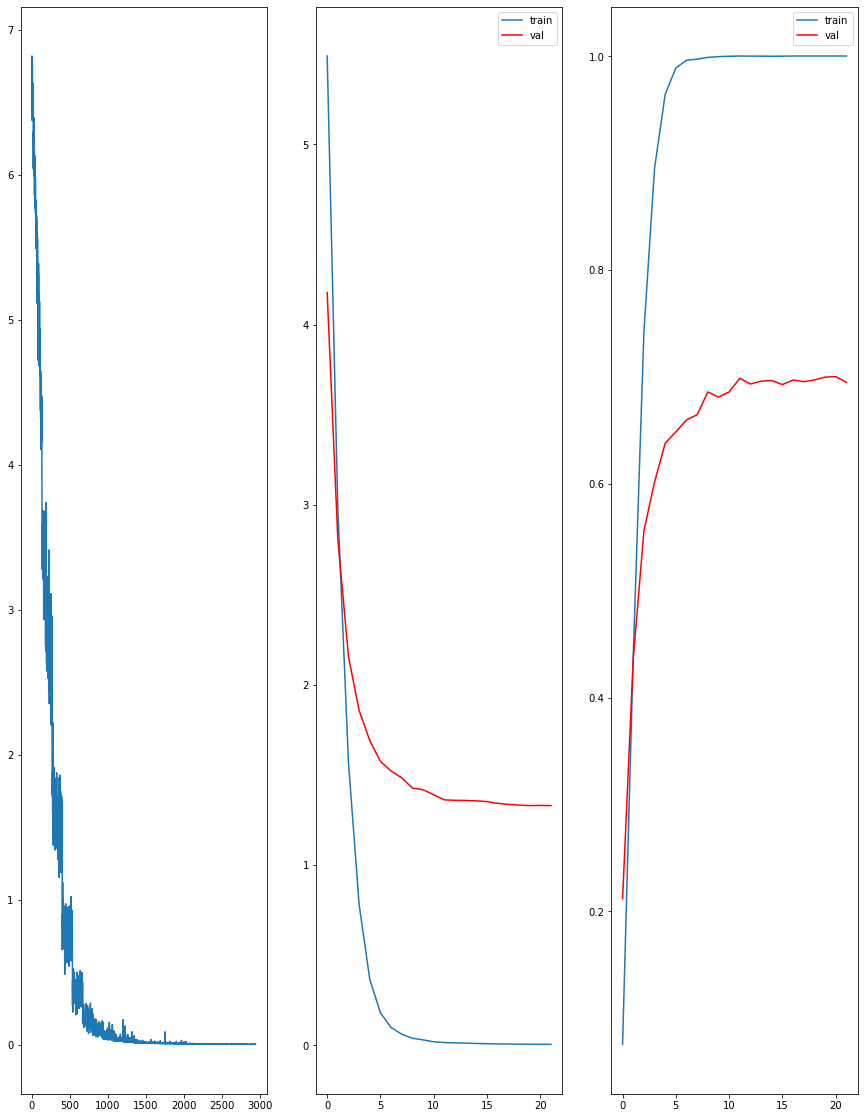

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0031, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22	 \Training Loss: 0.002779817578744199	     Validation Loss:1.3250860055287679	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.6980830430984497


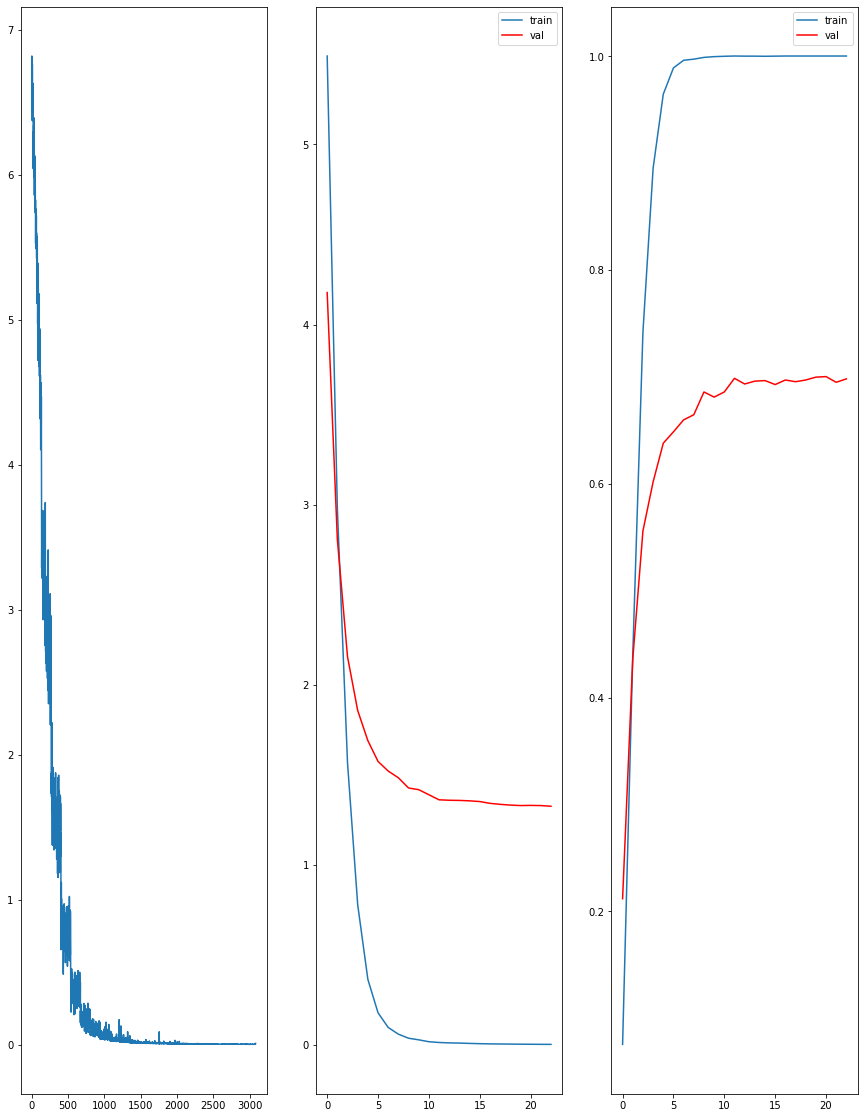

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23	 \Training Loss: 0.0025448615978986245	     Validation Loss:1.3148236672083538	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7002130150794983


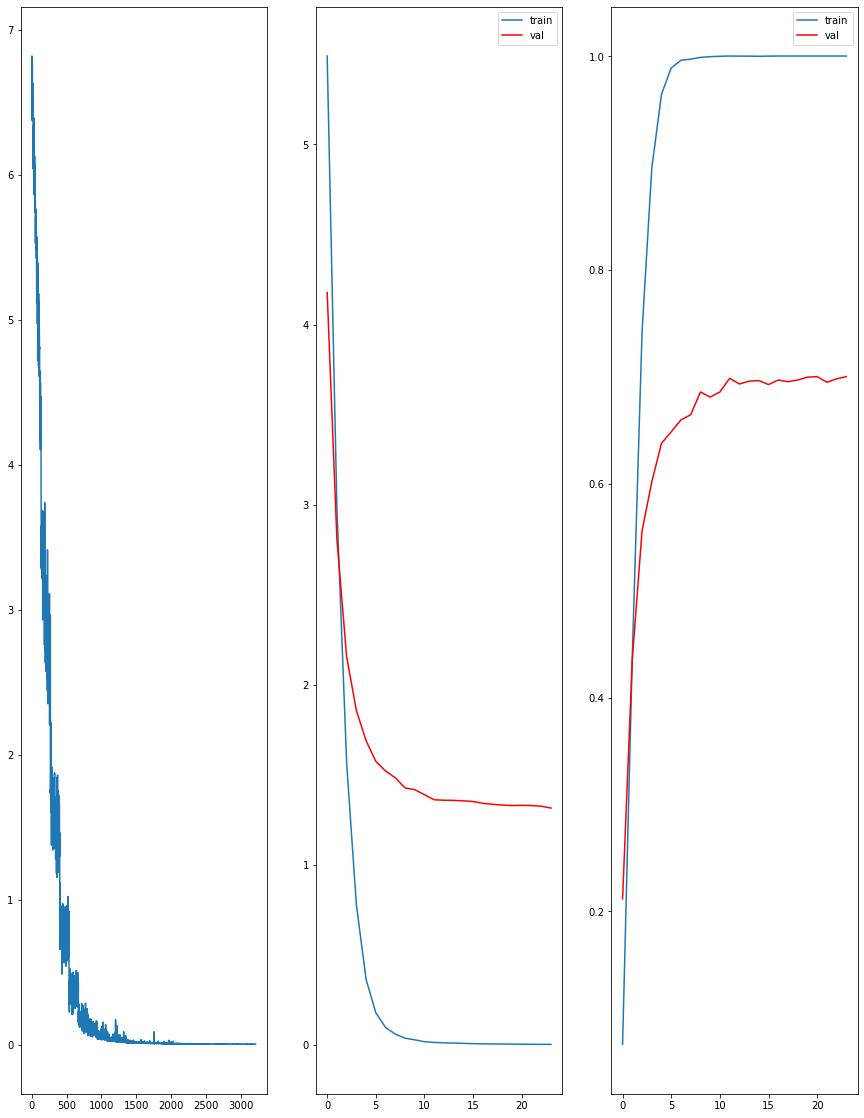

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24	 \Training Loss: 0.00230168590822549	     Validation Loss:1.3226748009522755	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7012779712677002


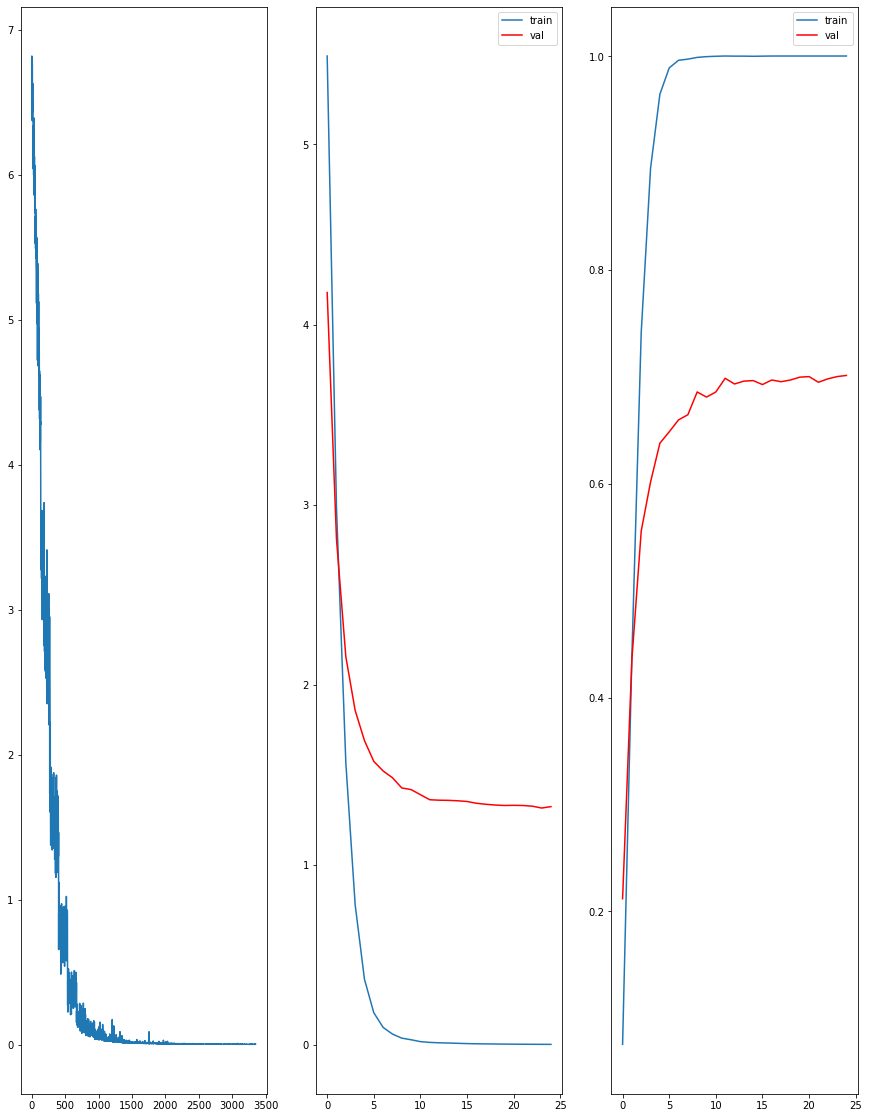

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25	 \Training Loss: 0.002055641717221866	     Validation Loss:1.3205012698968253	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.6975505948066711


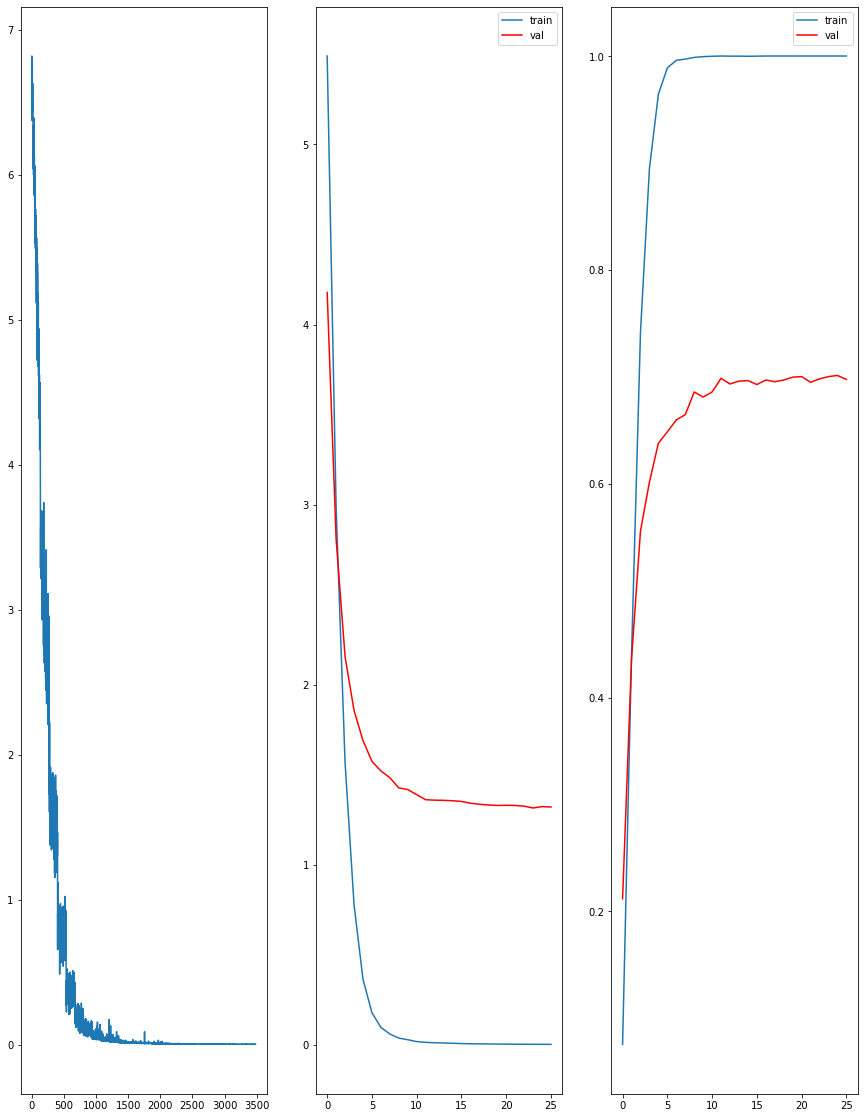

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 26	 \Training Loss: 0.0018884347796912736	     Validation Loss:1.3210306564966838	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.6970180869102478


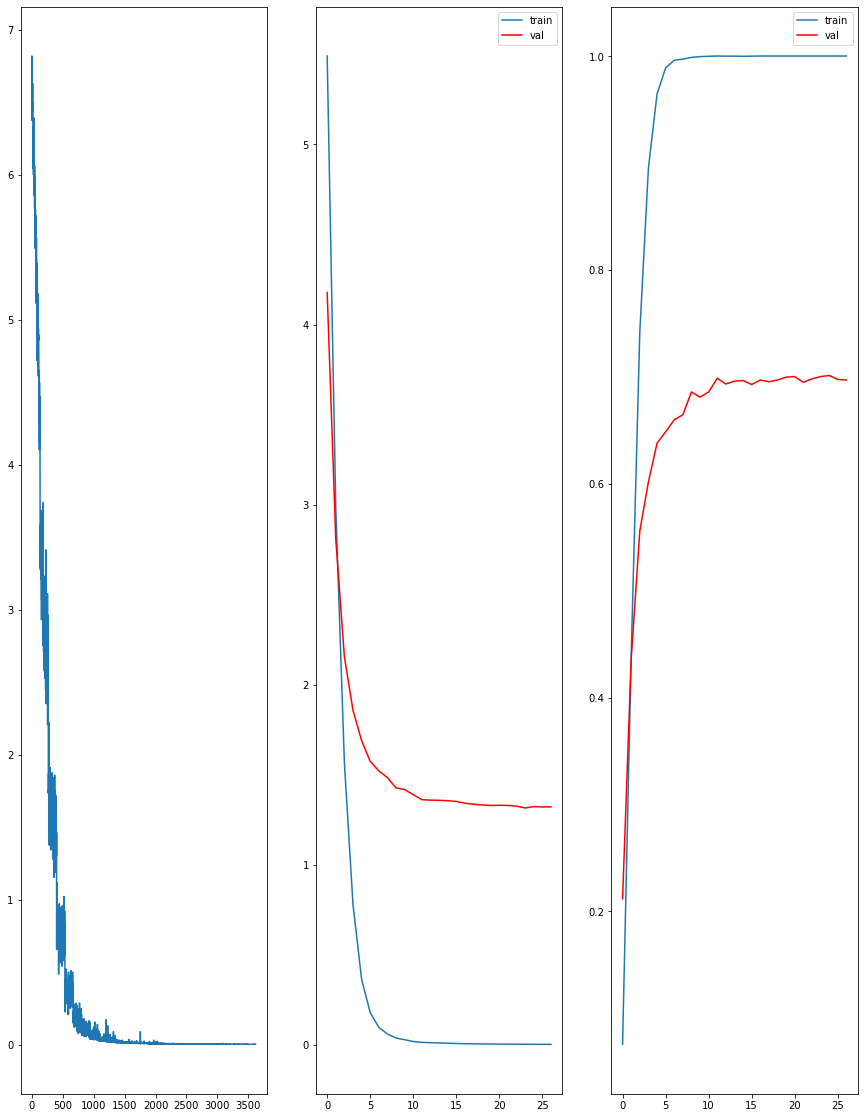

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27	 \Training Loss: 0.001719856021383694	     Validation Loss:1.3182203451792398	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7018104195594788


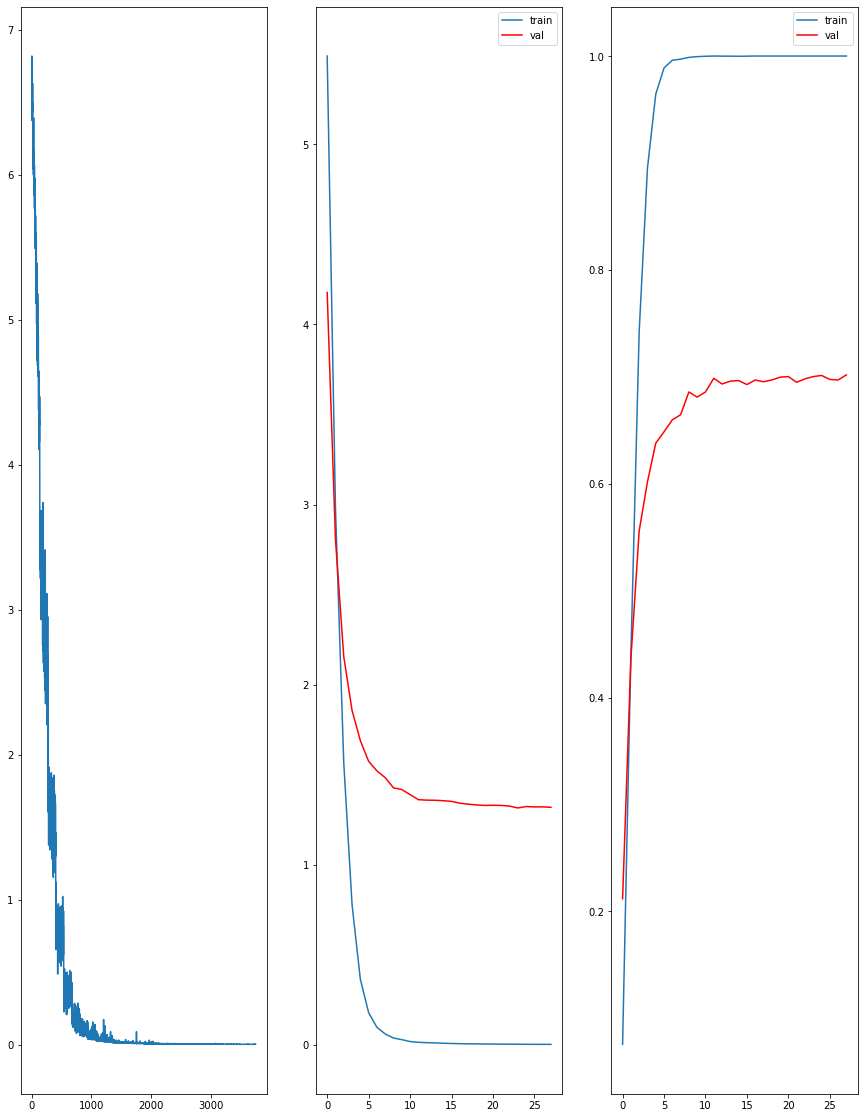

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 28	 \Training Loss: 0.0016033426622179016	     Validation Loss:1.3163545906543732	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7039403915405273


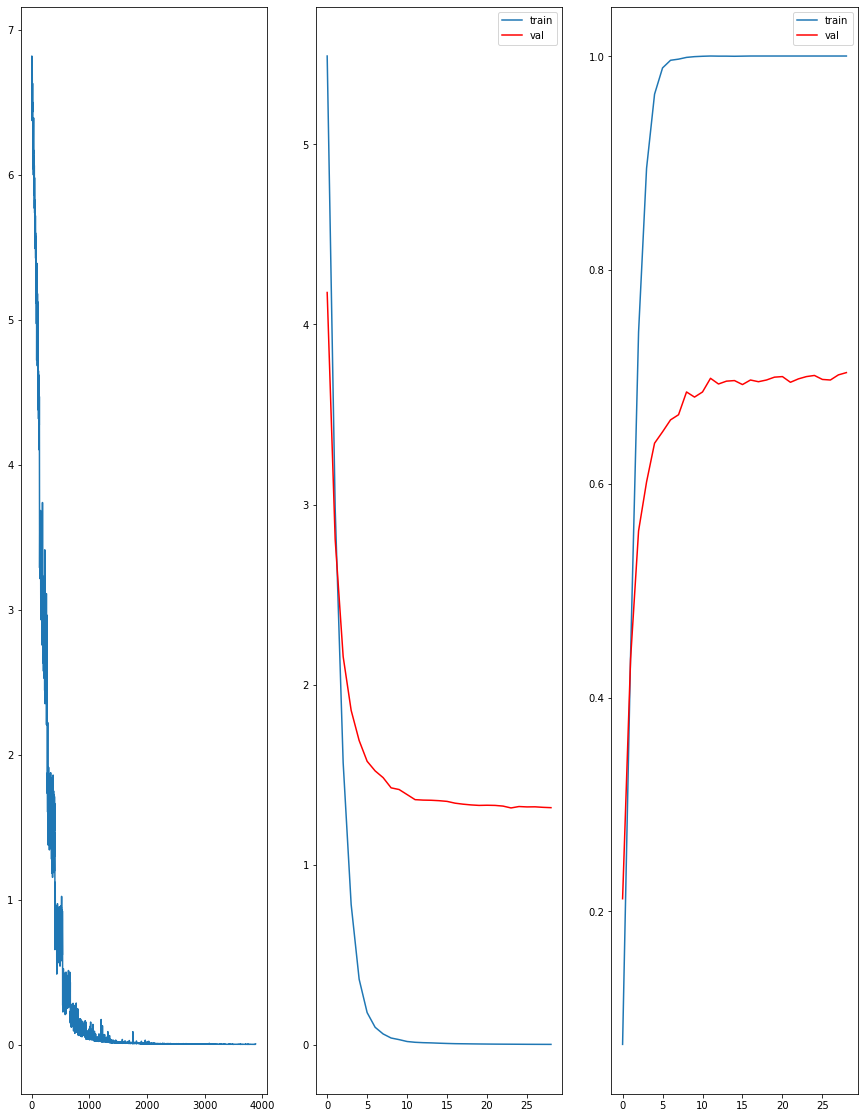

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29	 \Training Loss: 0.0014172106296685871	     Validation Loss:1.3138905783494315	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7039403915405273


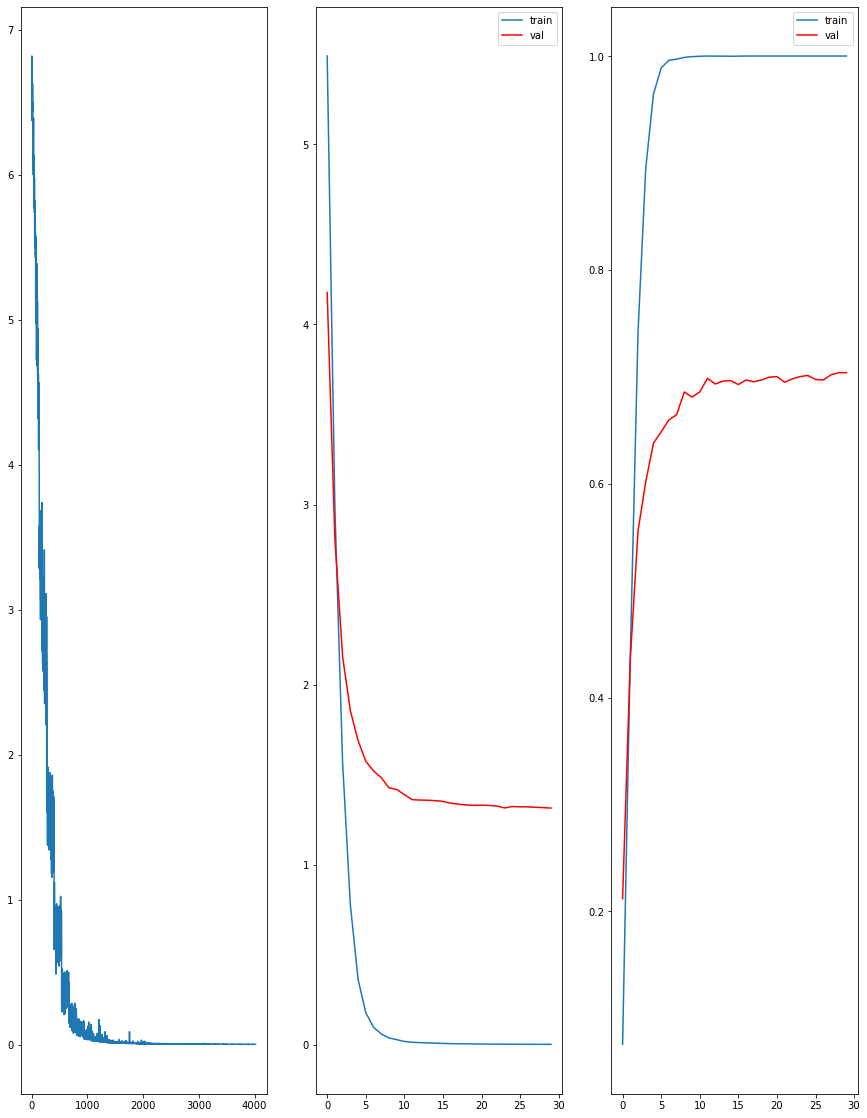

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30	 \Training Loss: 0.001316021087079017	     Validation Loss:1.3123600025971731	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7002130150794983


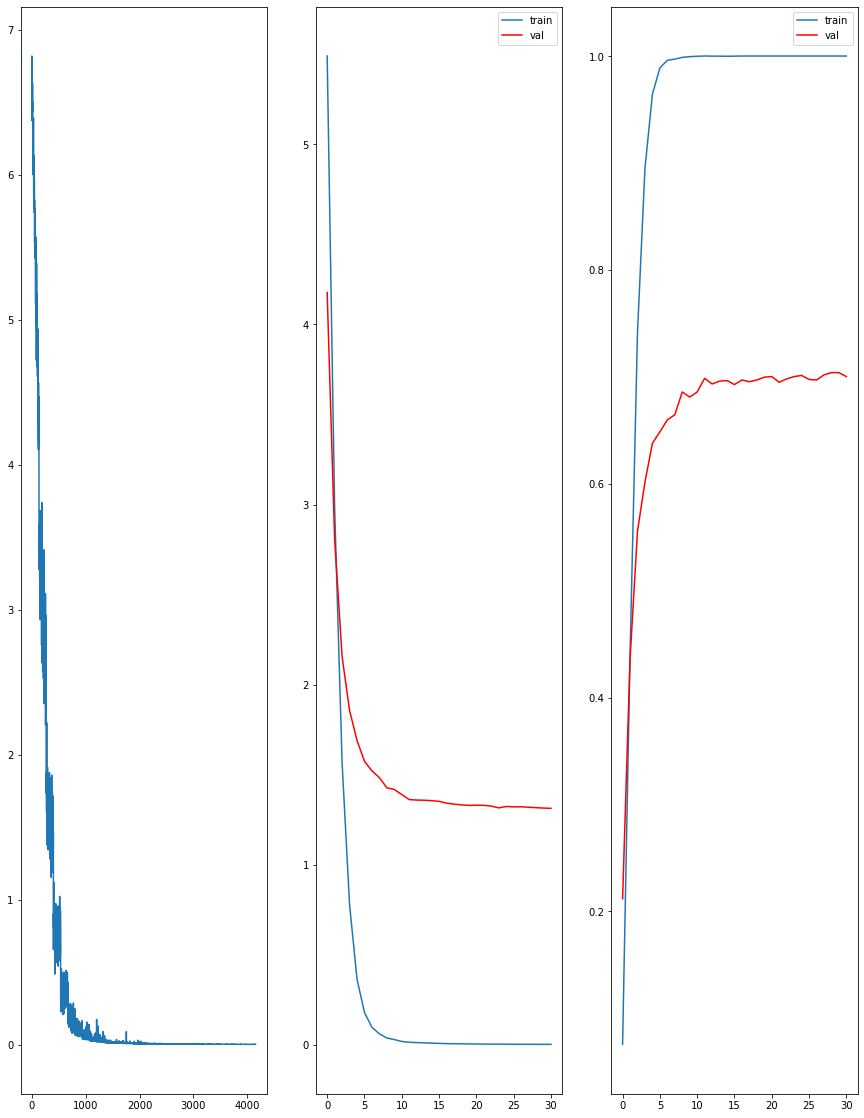

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 31	 \Training Loss: 0.0011995336876612212	     Validation Loss:1.315501077969869	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7002130150794983


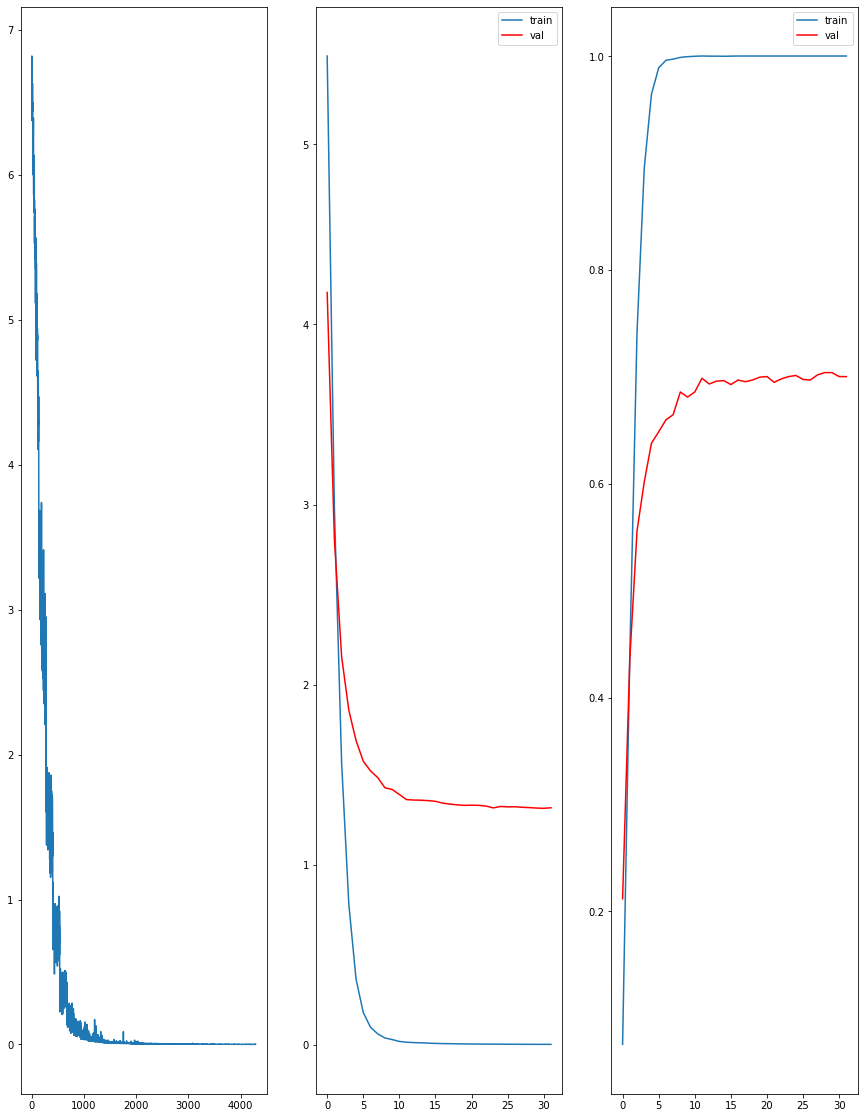

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 32	 \Training Loss: 0.0011054141170678854	     Validation Loss:1.3124090313911438	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7028753757476807


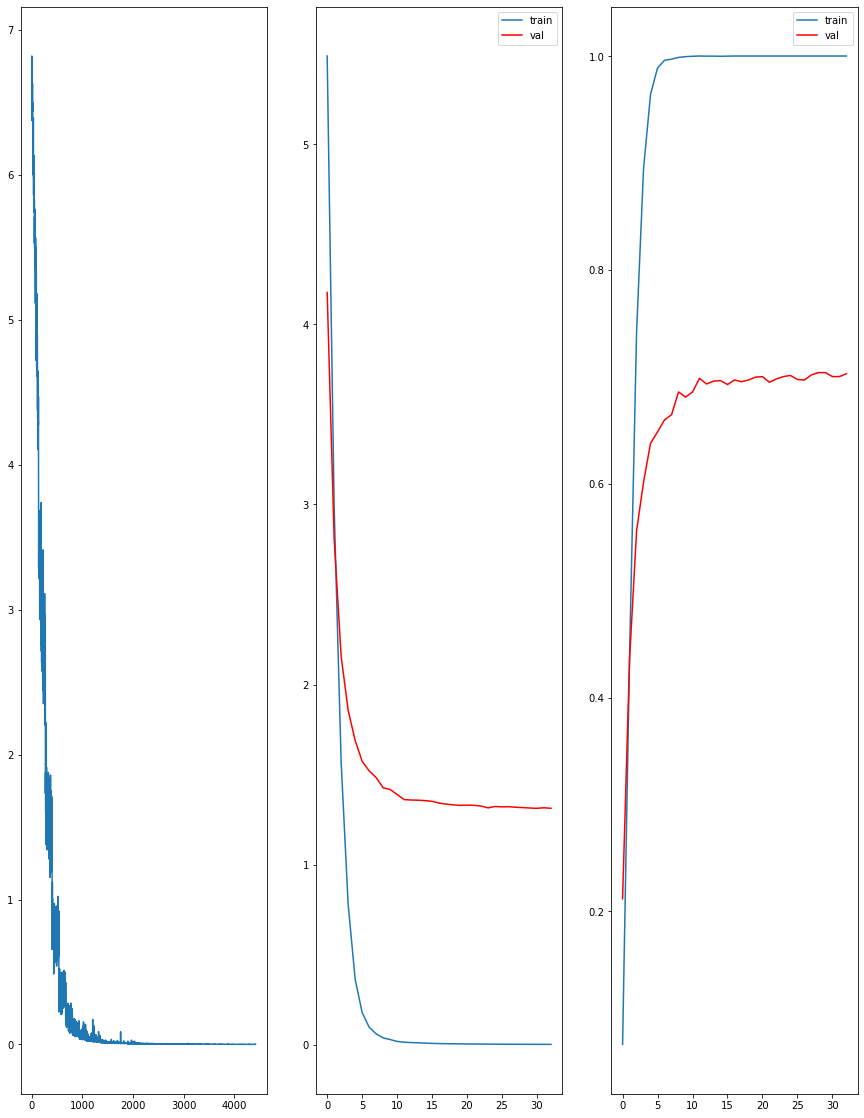

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 33	 \Training Loss: 0.0010267862604423634	     Validation Loss:1.3104578495025634	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7044728398323059


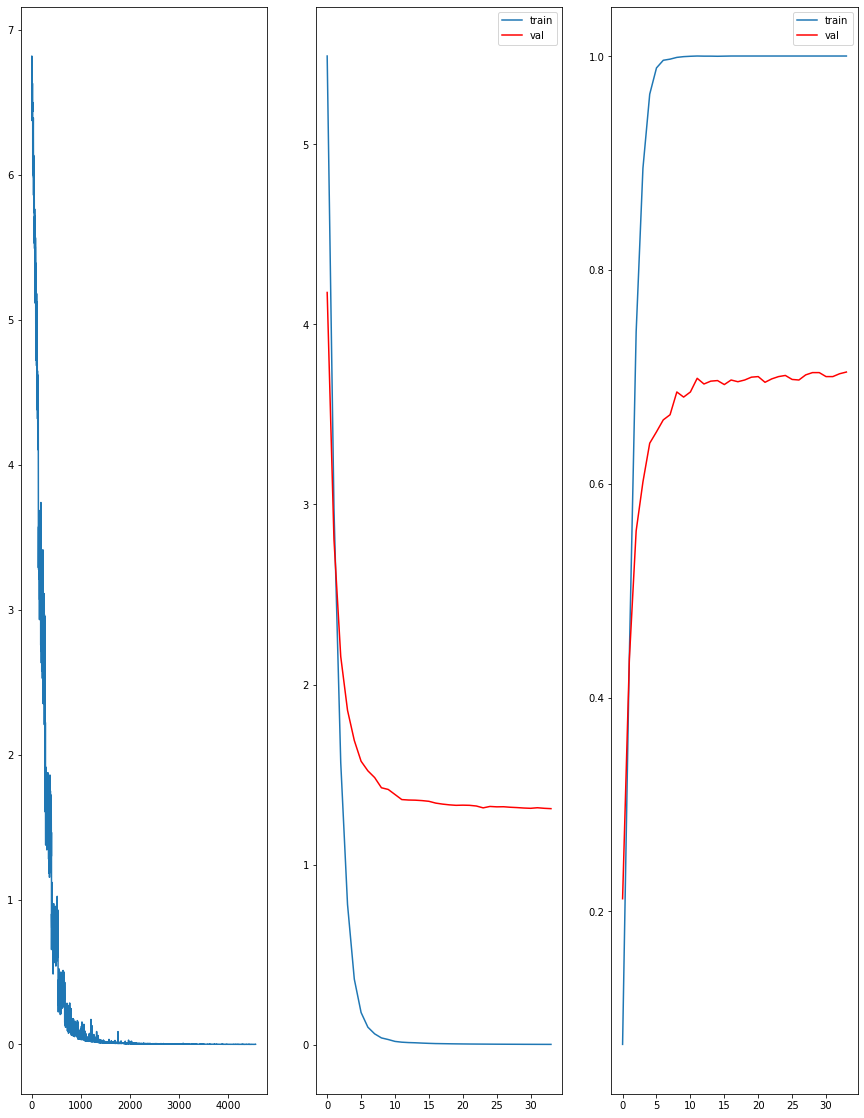

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 34	 \Training Loss: 0.0009213467771465432	     Validation Loss:1.3174425939718881	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.699680507183075


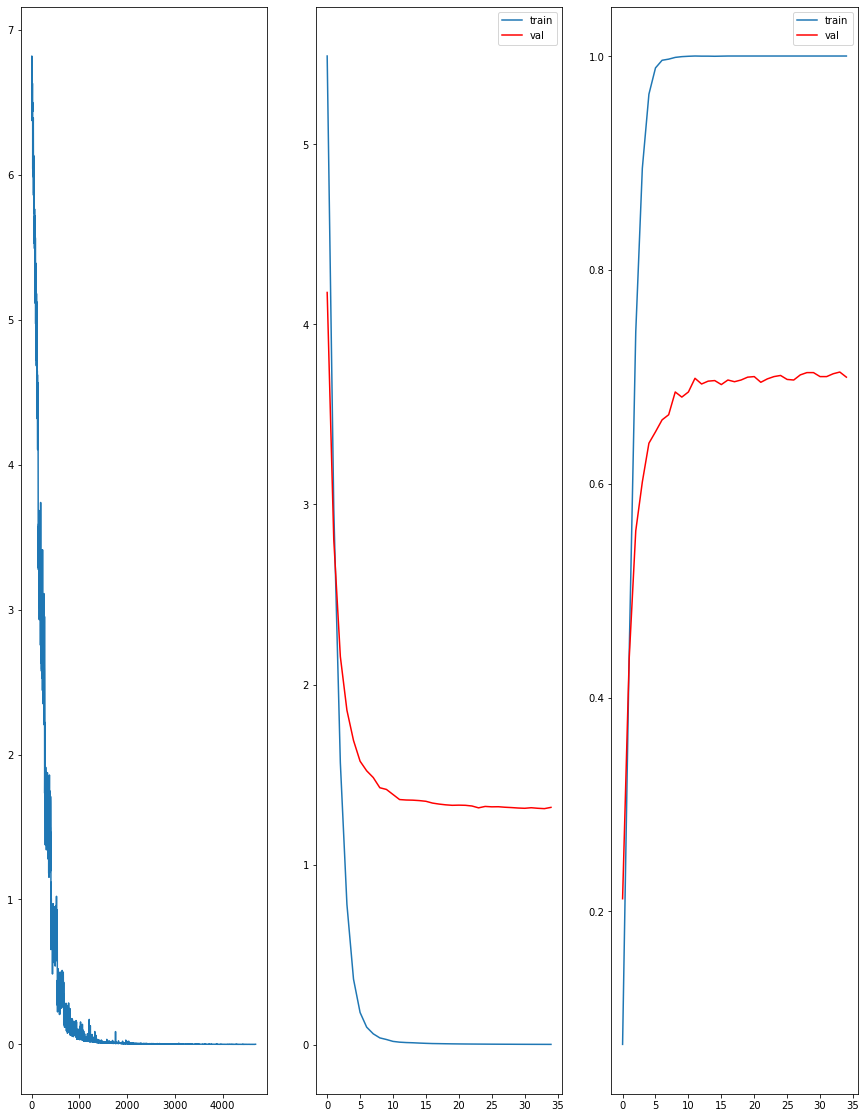

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0011, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 35	 \Training Loss: 0.0008698935601373773	     Validation Loss:1.308836696545283	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.703407883644104


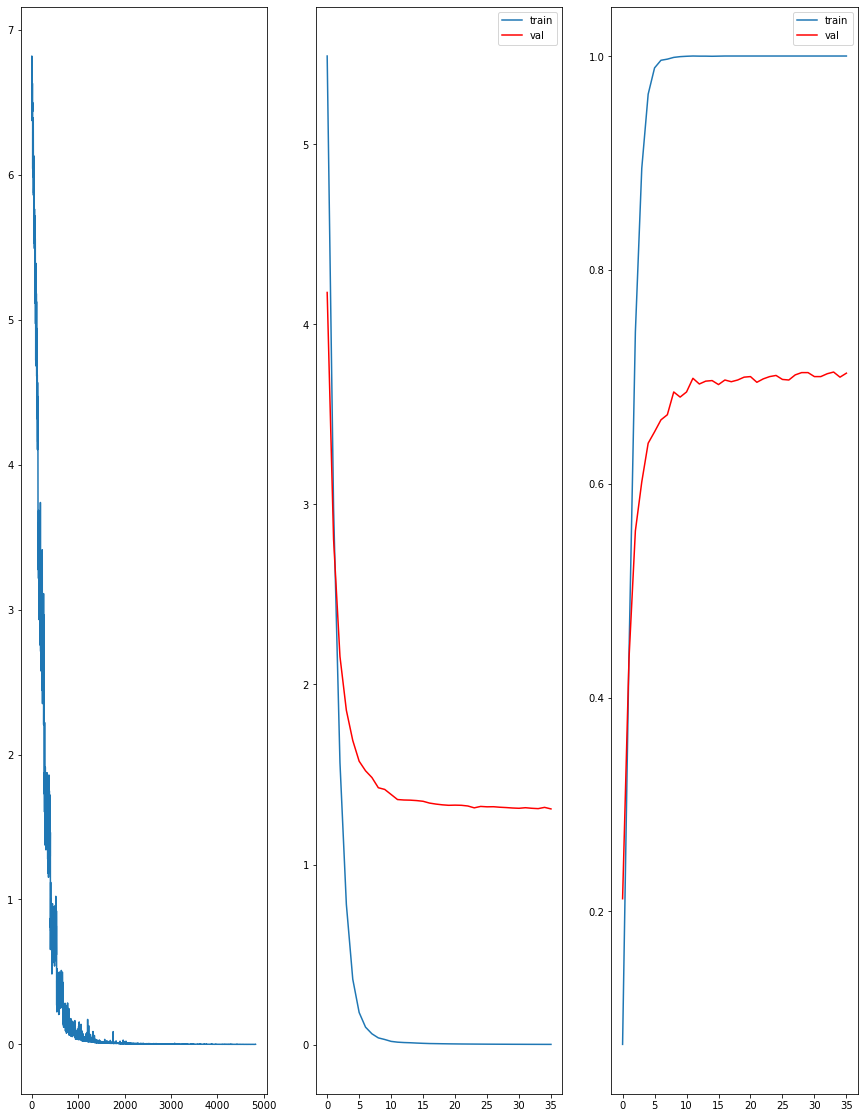

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0010, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 36	 \Training Loss: 0.0007784891436606257	     Validation Loss:1.3153350830078125	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.6991480588912964


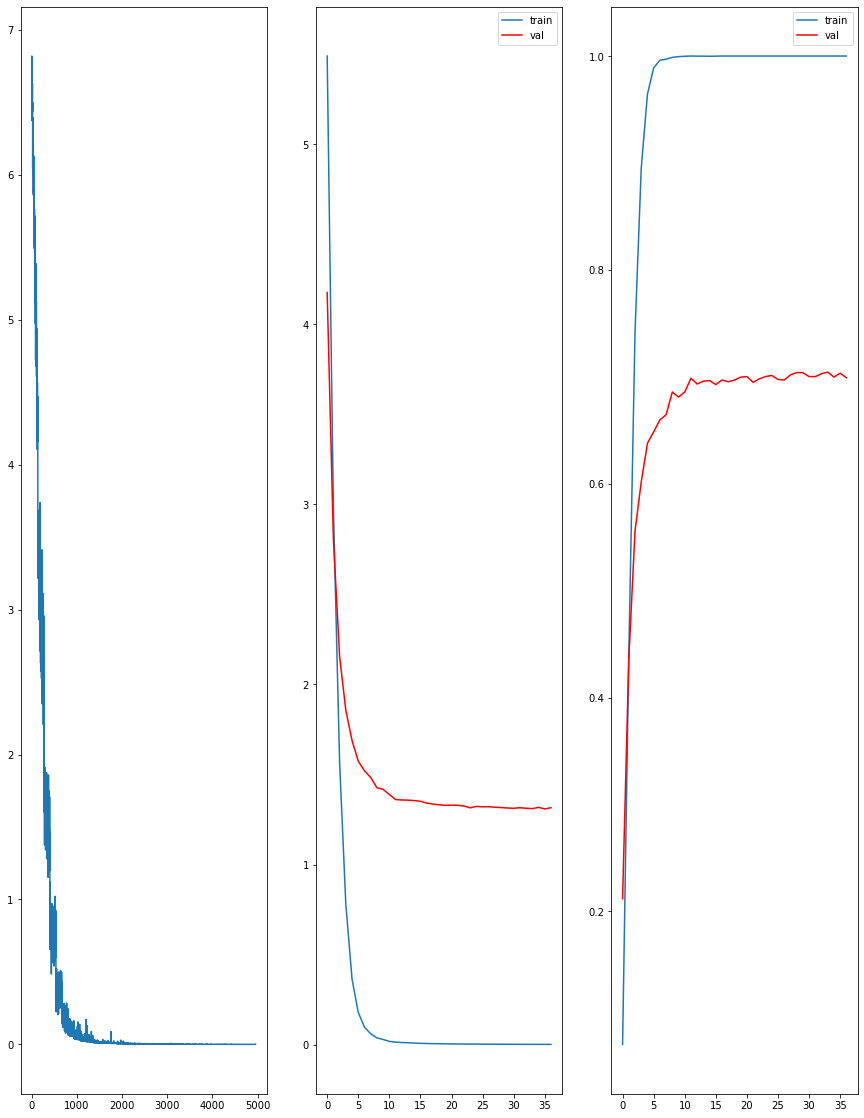

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 37	 \Training Loss: 0.0007181674567374415	     Validation Loss:1.3127116322517396	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.699680507183075


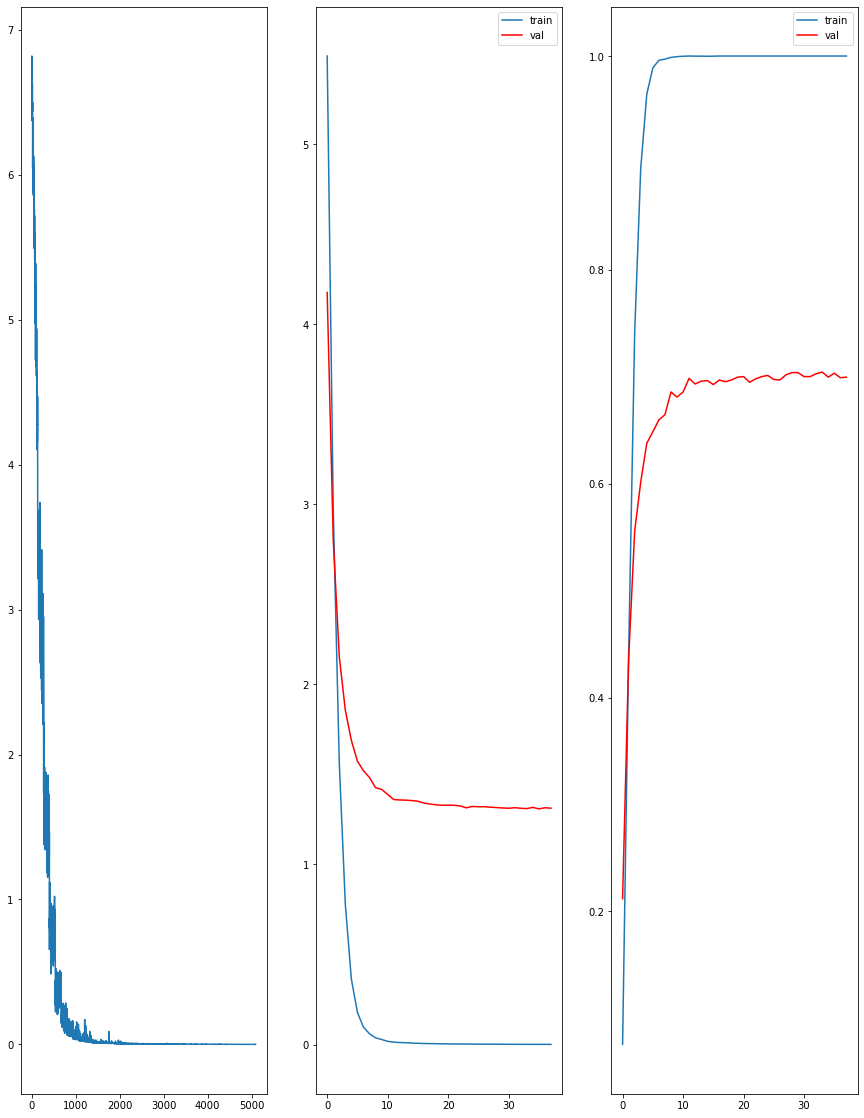

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0008, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 38	 \Training Loss: 0.0006700077267023109	     Validation Loss:1.3161271115144093	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.703407883644104


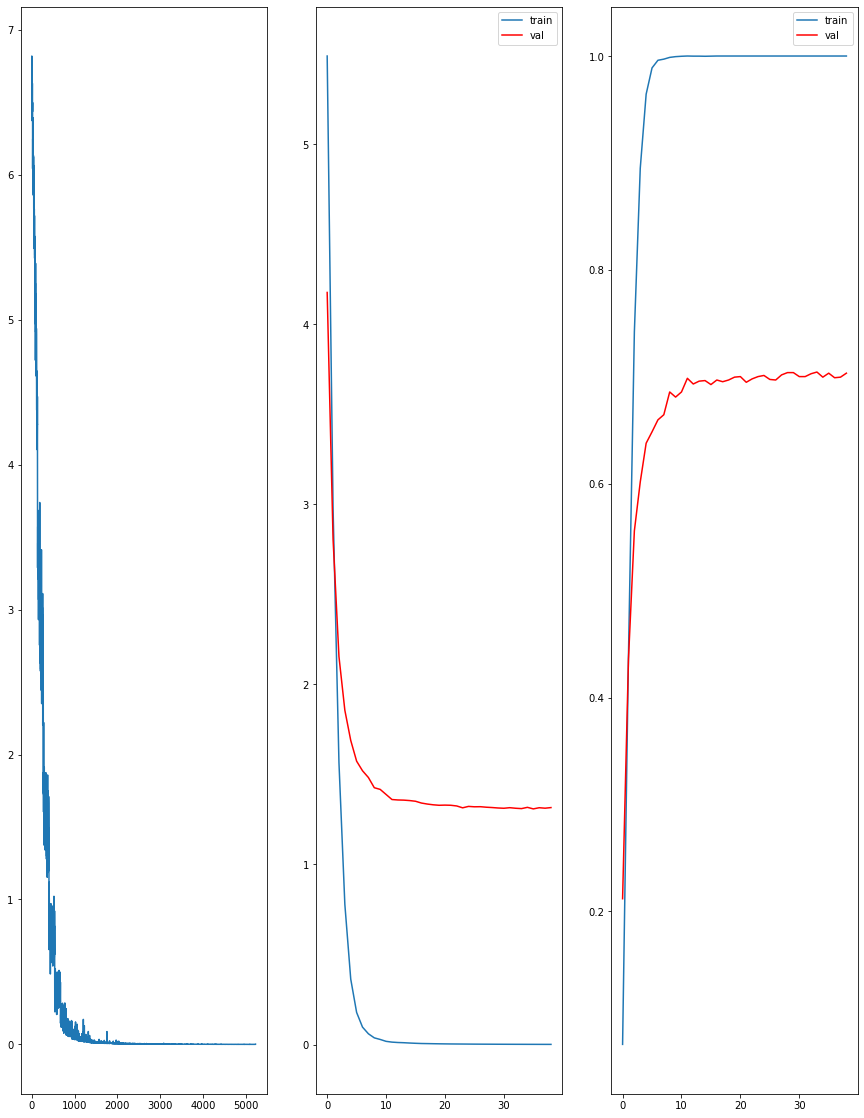

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0009, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 39	 \Training Loss: 0.0006069262264862852	     Validation Loss:1.3079643189907073	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.6991480588912964


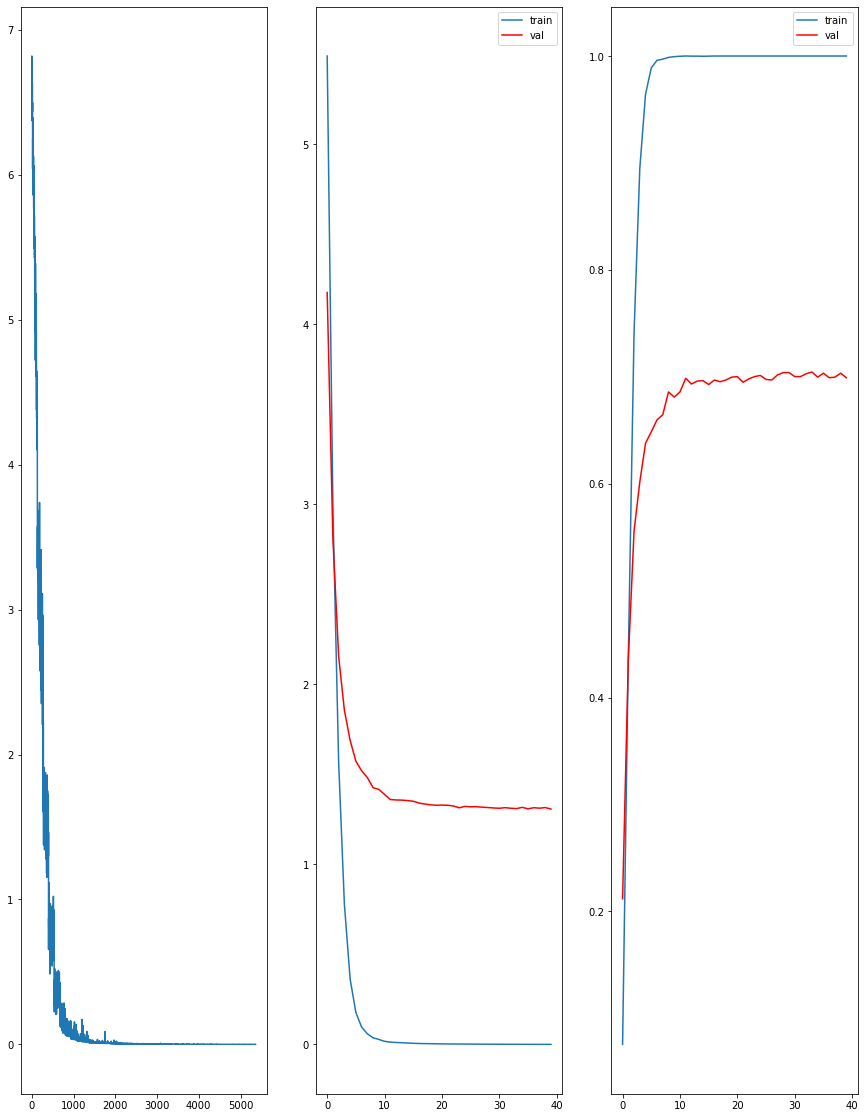

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 40	 \Training Loss: 0.0005641942092307858	     Validation Loss:1.310350481669108	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7007454633712769


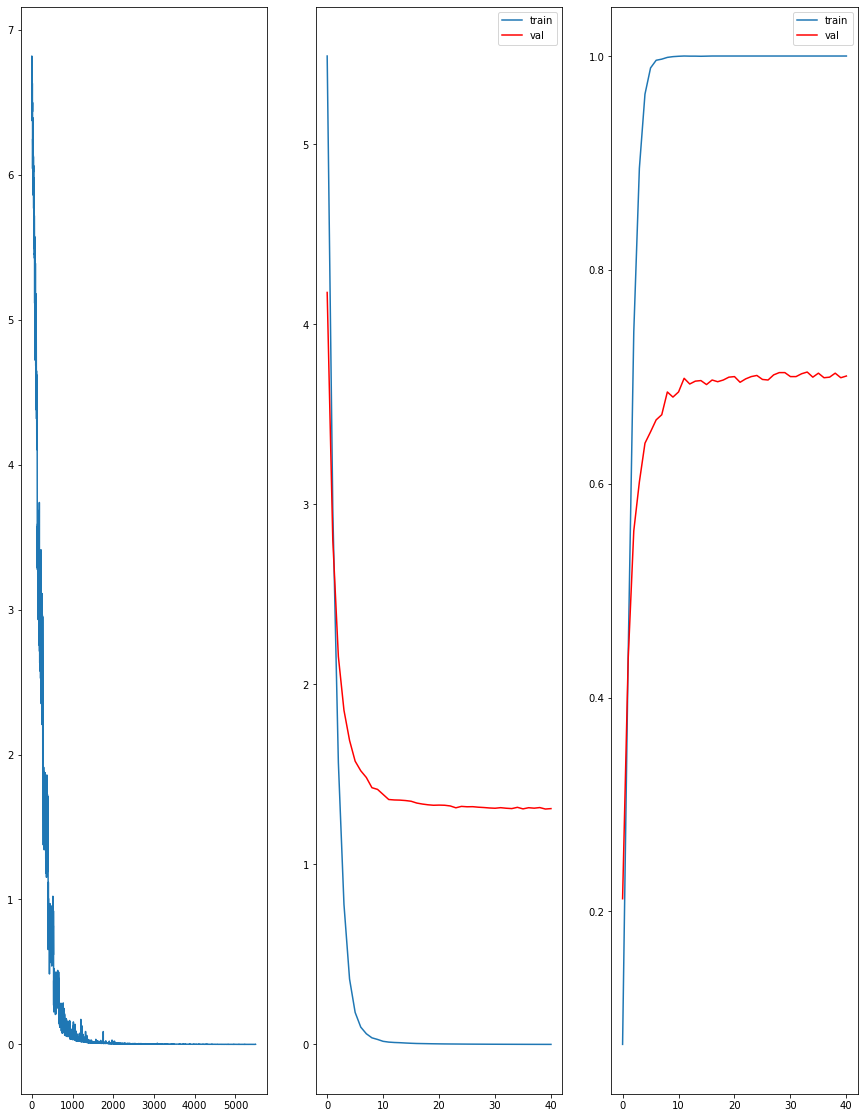

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 41	 \Training Loss: 0.0005222494623175503	     Validation Loss:1.306382840871811	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7087326645851135


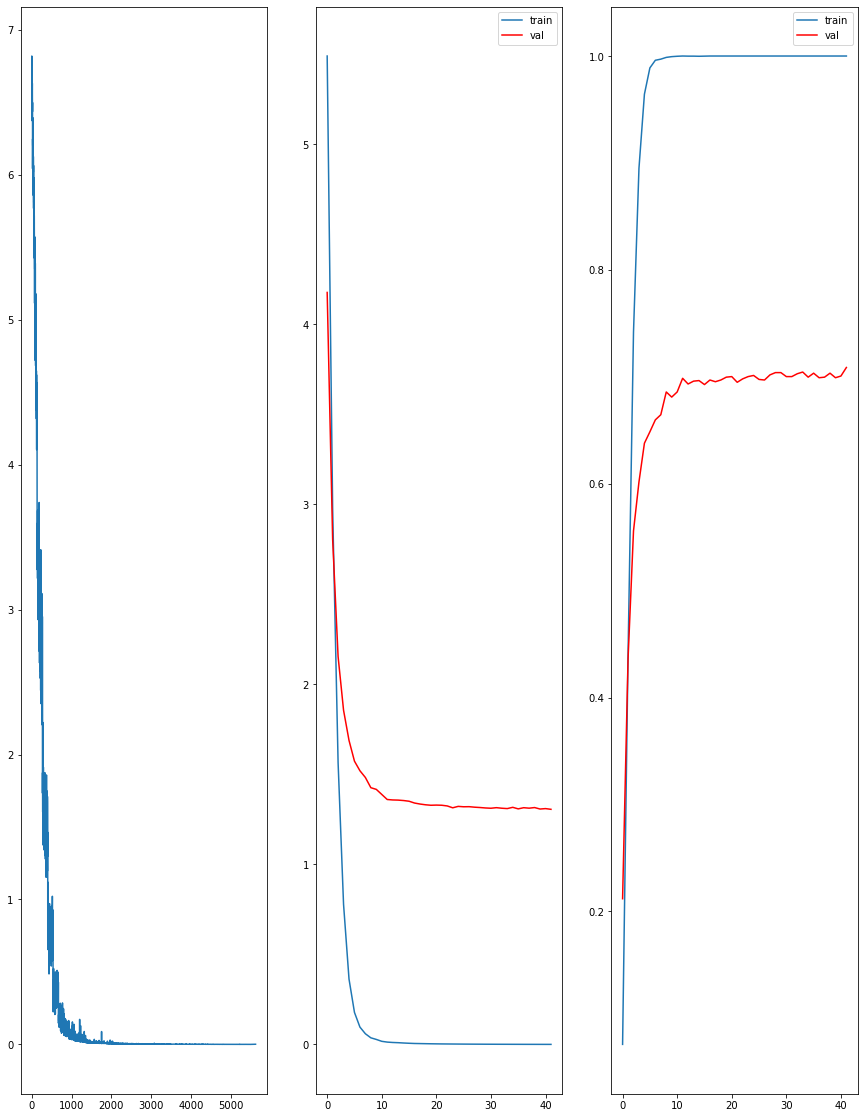

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 42	 \Training Loss: 0.0004787778083509557	     Validation Loss:1.3110550582408904	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7066027522087097


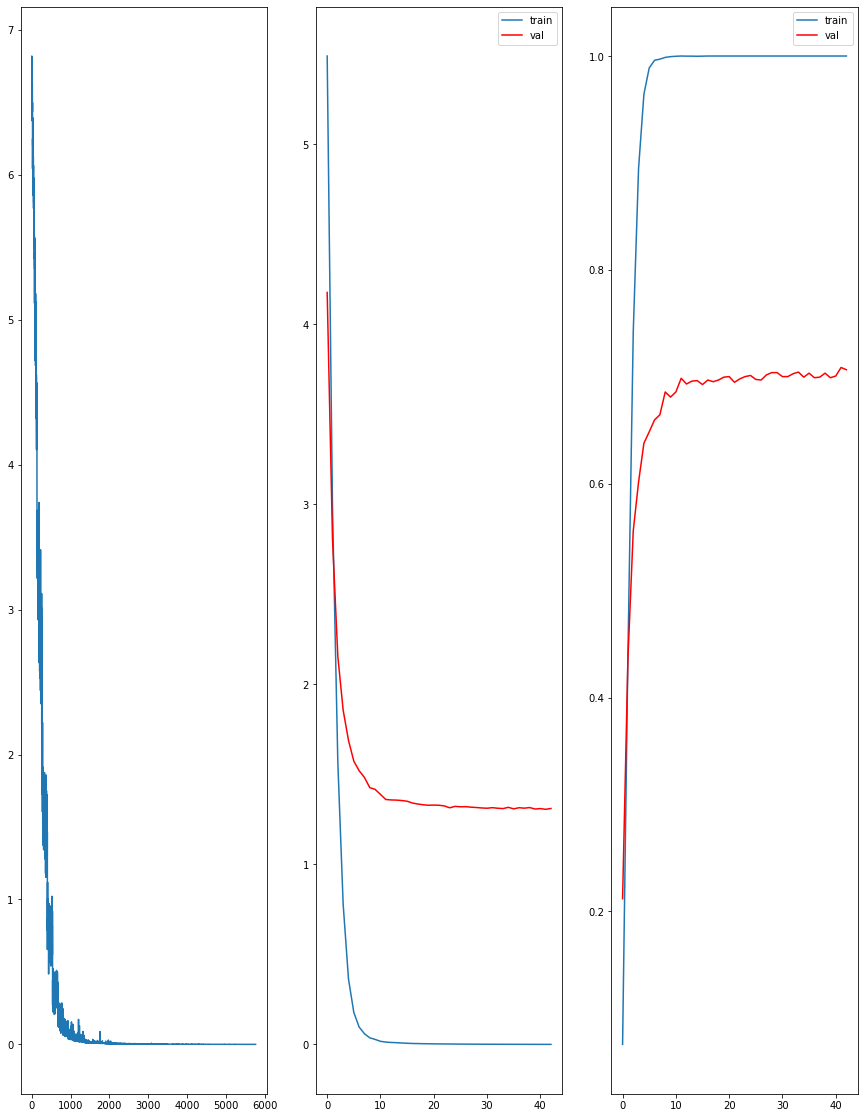

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 43	 \Training Loss: 0.00045166108448843736	     Validation Loss:1.309159262975057	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7087326645851135


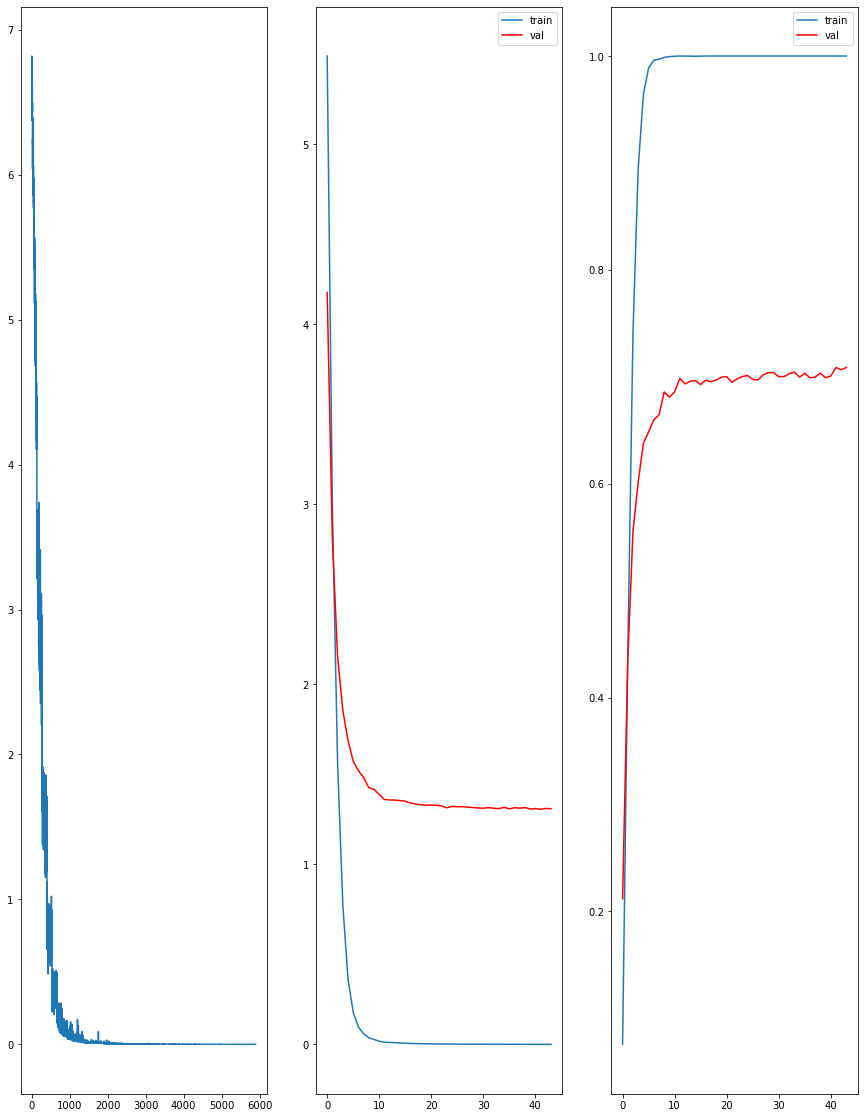

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 44	 \Training Loss: 0.0004132354789267558	     Validation Loss:1.3088980356852213	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7060703039169312


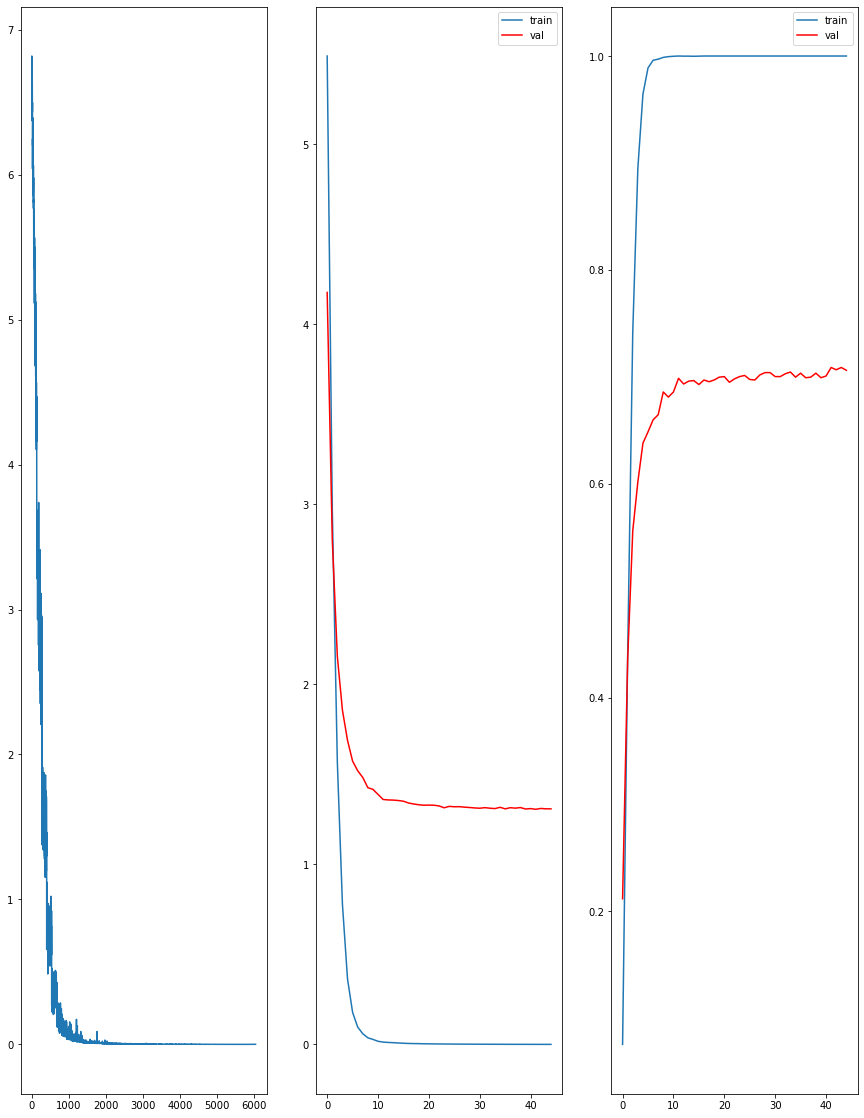

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 45	 \Training Loss: 0.0003835663456580977	     Validation Loss:1.3107321163018544	 \LR:0.0001	     accuracy_trin: 1.0	 ccuracy_val: 0.7044728398323059


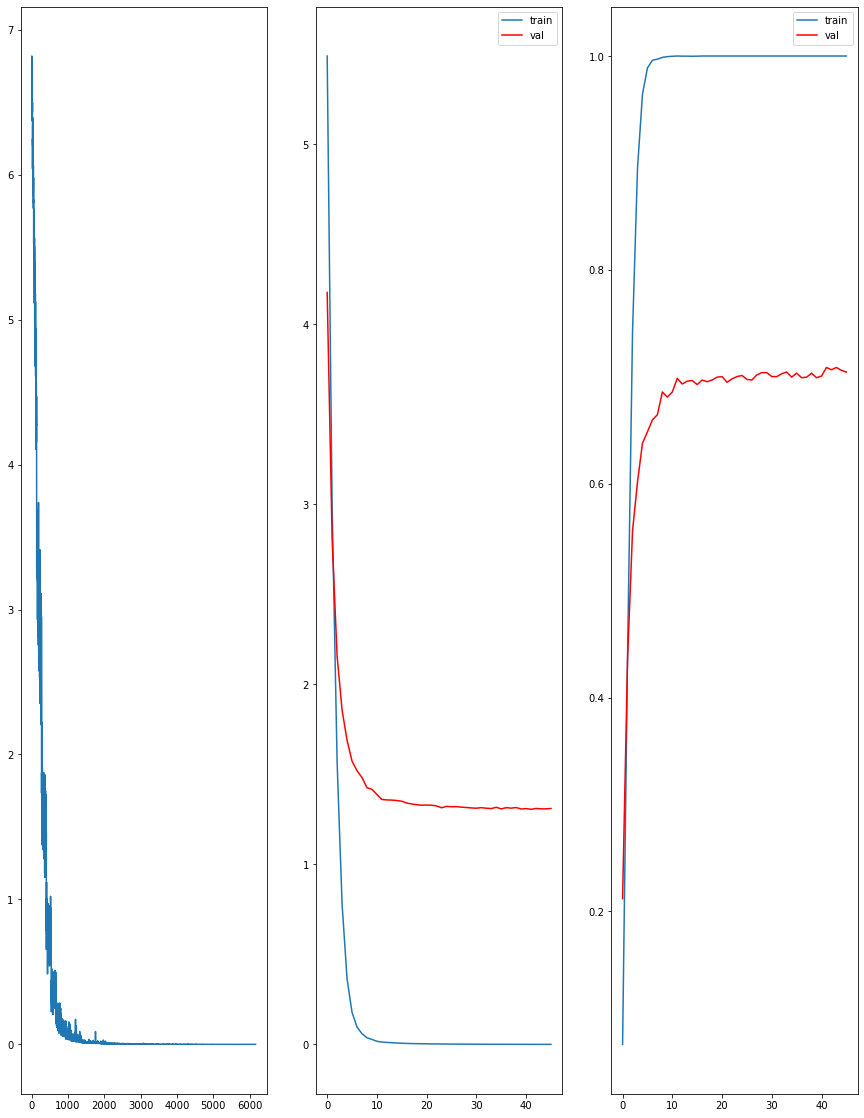

  0%|          | 0/134 [00:00<?, ?it/s]

tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0004, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)


KeyboardInterrupt: 

In [31]:
from torch.autograd import Variable
from tqdm.notebook import tqdm
step_losses = []
epoch_losses_train = []
epoch_losses_val = []
accuracy_trin = []
accuracy_val = []

for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_loss_val = 0
    num_correct_train = 0
    num_elements_train = 0
    num_correct_val = 0
    num_elements_val = 0
    model.train()
    for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        X, Y = batch['image'], batch['label']
        num_elements_train += len(Y)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        print(loss)
        y_pred = torch.argmax(Y_pred, dim=1)
        num_correct_train += torch.sum(y_pred == Y)
    if epoch % 5 == 0:
        state = {'info':  "resnet18 pretrained"+str(optimizer.param_groups[0]['lr']),            # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model' :    model.state_dict(),        # параметры модели
         'optimizer': optimizer.state_dict()}    # состояние оптимизатора
        torch.save(state, '/Fase_resnet18_pretrained_' + str(epoch)+ '.pth')
    with torch.no_grad():
        model.eval()
        for i, batch in tqdm(enumerate(val_loader), total=len(val_loader), leave=False):
            X, Y = batch['image'], batch['label']
            num_elements_val += len(Y)
            Y_pred = model(X)
            loss_val = criterion(Y_pred, Y)
            epoch_loss_val += loss_val.item()
            y_pred = torch.argmax(Y_pred, dim=1)
            num_correct_val += torch.sum(y_pred == Y)
    accuracy_trin.append(num_correct_train / num_elements_train)
    accuracy_val.append(num_correct_val / num_elements_val)
    epoch_losses_val.append(epoch_loss_val/len(val_loader))
    epoch_losses_train.append(epoch_loss/len(train_loader))
    scheduler.step(epoch_loss_val/len(val_loader))
    curr_lr = optimizer.param_groups[0]['lr']
  
    print(f'Epoch {epoch}\t \Training Loss: {epoch_loss/len(train_loader)}\t \
    Validation Loss:{epoch_loss_val/len(val_loader)}\t \LR:{curr_lr}\t \
    accuracy_trin: {num_correct_train / num_elements_train}\t \accuracy_val: {num_correct_val / num_elements_val}')
    fig, axes = plt.subplots(1, 3, figsize=(15, 20))
    axes[0].plot(step_losses)
    axes[1].plot(epoch_losses_train, label = 'train')
    axes[1].plot(epoch_losses_val, color = 'red', label = 'val')
    axes[1].legend()
    axes[2].plot(accuracy_trin, label = 'train')
    axes[2].plot(accuracy_val, color = 'red', label = 'val')
    axes[2].legend()
    plt.show()


In [9]:
state = torch.load('/Fase_resnet18_pretrained_35.pth', map_location=torch.device('cpu'))
model = resnet18(pretrained_model=pretrained_model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(state['model'])        # получаем параметры модели
optimizer.load_state_dict(state['optimizer'])    # получаем состояние оптимизатора

print(state['info'], state['date'])

resnet18 pretrained0.0001 2023-01-25 10:05:56.324917


In [19]:
from tqdm.notebook import tqdm
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0
    

    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        
        with torch.no_grad():
            model.eval()
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    accuracy = num_correct / num_elements
            
    return accuracy.numpy(), np.mean(losses)

In [20]:
test_accuracy, test_loss = evaluate(model, test_loader, criterion)
test_accuracy, test_loss

  0%|          | 0/25 [00:00<?, ?it/s]

(array(0.72057897, dtype=float32), 1.3753740191459656)

**Cosine similarity calculation**: drop the last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Let's check if there is a big difference in any of the cases?

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [12]:
model.pretrained.last_linear.register_forward_hook(get_features('embeddings'))

In [13]:
PREDS = []
FEATS = []

# placeholder for batch features
features = {}

# loop through batches
for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
        
    X_batch, y_batch = batch['image'], batch['label']
       
    # forward pass [with feature extraction]
    preds = model(X_batch)
    
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features['embeddings'].cpu().numpy())


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:19<00:00,  3.20s/it]


In [60]:
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)

- preds shape: (1589, 500)
- feats shape: (1589, 1000)


In [77]:
batch_train = iter(train_loader).next()
batch_train['label']

tensor([ 37, 338,  37, 426,   8, 350, 231, 357, 168, 130,   3, 126, 279, 187,
        160, 167, 251, 187, 100, 129,  44,  64,   6, 380,   5, 192, 396, 408,
         37, 337, 137, 215, 200, 111, 388, 356, 134,  15, 118, 437, 185, 359,
         89, 336, 402, 498, 130, 340,  30, 338, 234,   5, 104, 159, 143, 299,
        340, 482, 129, 211,  43, 202, 468,  93])

In [79]:
batch_test = iter(test_loader).next()
batch_test['label']

tensor([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,
         4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,
         9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14,
        14, 14, 15, 15, 15, 15, 16, 16, 16, 17])

In [80]:
def Cosine_similarity(model, x1, x2):
    with torch.no_grad():
        model.eval()
        preds_1 = model(x1)
        embed_1 = features['embeddings'].cpu().numpy()
        preds_2 = model(x2)
        embed_2 = features['embeddings'].cpu().numpy()
        cos = cosine_similarity(embed_1, embed_2)
        return cos

In [86]:
# 8 c 8
print(Cosine_similarity(model, torch.unsqueeze(batch_train['image'][4], dim=0), torch.unsqueeze(batch_test['image'][32], dim=0)))
# 8 c 5
print(Cosine_similarity(model, torch.unsqueeze(batch_train['image'][4], dim=0), torch.unsqueeze(batch_test['image'][19], dim=0)))
# 5 c 8 
print(Cosine_similarity(model, torch.unsqueeze(batch_train['image'][51], dim=0), torch.unsqueeze(batch_test['image'][32], dim=0)))
# 5 c 5
print(Cosine_similarity(model, torch.unsqueeze(batch_train['image'][51], dim=0), torch.unsqueeze(batch_test['image'][19], dim=0)))

[[0.42939162]]
[[0.15375893]]
[[-0.06854526]]
[[0.579033]]


Text(0.5, 1.0, '5 test')

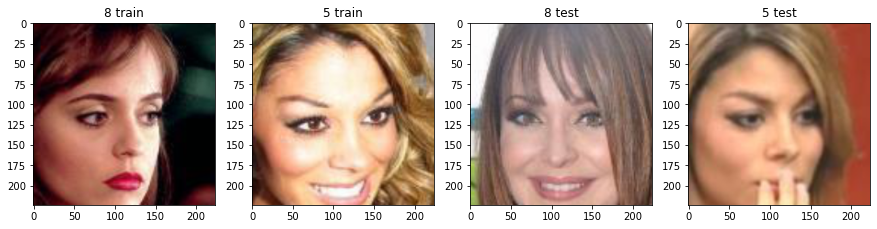

In [88]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])
fig, axes = plt.subplots(1, 4, figsize=(3*5, 9*5))


axes[0].imshow(inverse_transform(batch_train['image'][4]).permute(1, 2, 0).cpu().detach().numpy())
axes[0].set_title("8 train")
axes[1].imshow(inverse_transform(batch_train['image'][51]).permute(1, 2, 0).cpu().detach().numpy())
axes[1].set_title("5 train")
axes[2].imshow(inverse_transform(batch_test['image'][32]).permute(1, 2, 0).cpu().detach().numpy())
axes[2].set_title("8 test")
axes[3].imshow(inverse_transform(batch_test['image'][19]).permute(1, 2, 0).cpu().detach().numpy())
axes[3].set_title("5 test")

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

Visualize (build histograms) the cosine similarities distributions for same and different people.

In [14]:
transform = transforms.Compose([
      # you may add anything, e.g. augmentation
    transforms.CenterCrop((120,120)),  
    transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)])
train_data_cos = celebADataset('train', transform, augmentation)
val_data_cos = celebADataset('val', transform)
test_data_cos = celebADataset('test', transform)

# choose your own batch_size
batch_size = 64
train_loader_cos = torch.utils.data.DataLoader(train_data_cos, batch_size=batch_size, shuffle=False)
val_loader_cos = torch.utils.data.DataLoader(val_data_cos, batch_size=batch_size, shuffle=False)
test_loader_cos = torch.utils.data.DataLoader(test_data_cos, batch_size=batch_size, shuffle=False)

In [15]:
len(train_data_cos)

8544

In [16]:
def Cosine_similarity(model, x1, x2):
    model.eval()
    preds_1 = model(x1)
    embed_1 = features['embeddings'].cpu().numpy()
    preds_2 = model(x2)
    embed_2 = features['embeddings'].cpu().numpy()
    cos = cosine_similarity(embed_1, embed_2)
    return cos

In [17]:
images_train = []
lables_train = []

for i, batch in tqdm(enumerate(train_loader_cos), total=len(train_loader_cos)):
        
    X_batch, y_batch = batch['image'], batch['label']
    
    images_train.append(X_batch.detach().cpu().numpy())
    lables_train.append(y_batch.detach().cpu().numpy())
Images_train = np.concatenate(images_train)
Lables_train = np.concatenate(lables_train)



100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:34<00:00,  3.85it/s]


In [18]:
images_test = []
lables_test = []

for i, batch in tqdm(enumerate(test_loader_cos), total=len(test_loader_cos)):
        
    X_batch, y_batch = batch['image'], batch['label']
    
    images_test.append(X_batch.detach().cpu().numpy())
    lables_test.append(y_batch.detach().cpu().numpy())
Images_test = np.concatenate(images_test)
Lables_test = np.concatenate(lables_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.66it/s]


In [19]:
Images_train.shape

(8544, 3, 224, 224)

In [21]:
def cos_same_person(Images_train, Lables_train, Images_test, Lables_test):
    cos_person = []
    for i in tqdm(range(len(Images_test)), total=len(Images_test)):
        for j in range(len(Images_train)):
            if Lables_test[i] == Lables_train[j]:
                cos_person.append(Cosine_similarity(model, torch.unsqueeze(torch.from_numpy(Images_test[i]), dim=0), torch.unsqueeze(torch.from_numpy(Images_train[j]), dim=0)))
                break
    return cos_person

In [22]:
same_person = cos_same_person(Images_train, Lables_train, Images_test, Lables_test)


100%|██████████████████████████████████████████████████████████████████████████████| 1589/1589 [03:35<00:00,  7.37it/s]


AttributeError: 'list' object has no attribute 'shape'

In [32]:
same_person = np.array(same_person)
same_person.shape

(1589, 1, 1)

In [39]:
from random import randint
def cos_different_person(Images_train, Lables_train, Images_test, Lables_test):
    cos_person = []
    for i in tqdm(range(len(Images_train)), total=len(Images_train)):
        ind_test = randint(0, 1588)
        if Lables_train[i] != Lables_test[ind_test]:
            cos_person.append(Cosine_similarity(model, torch.unsqueeze(torch.from_numpy(Images_train[i]), dim=0), torch.unsqueeze(torch.from_numpy(Images_test[ind_test]), dim=0)))
    return cos_person

In [40]:
different_person = cos_different_person(Images_train, Lables_train, Images_test, Lables_test)
different_person = np.array(different_person)
different_person.shape

100%|██████████████████████████████████████████████████████████████████████████████| 8544/8544 [21:03<00:00,  6.76it/s]


(8524, 1, 1)

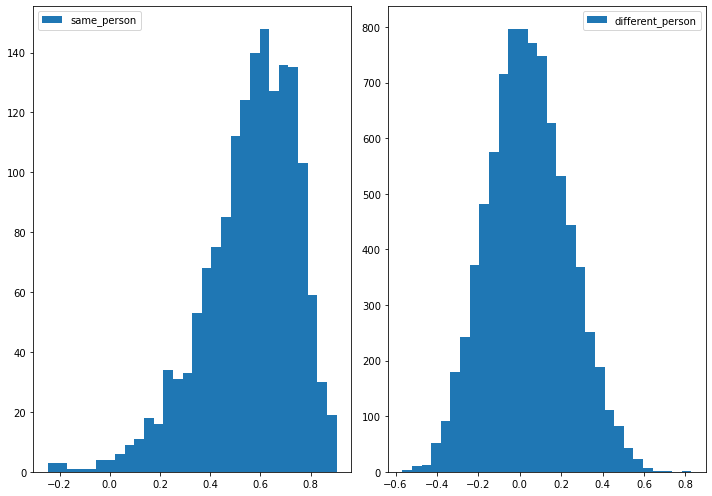

In [43]:
fig, axs = plt.subplots(1, 2,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs[0].hist(np.resize(same_person, 1589), bins = 30, label = 'same_person')
axs[1].hist(np.resize(different_person, 8524), bins = 30, label = 'different_person')
axs[0].legend()
axs[1].legend()
plt.show()